In [1]:
#This notebook is going to use the accelwattch_results to compare simulated and measured power
#Note that the hw_power_results.csv was generated from the power_temp_analysis.ipynb
#While the accelwattch_volta_sass_hw.csv was generated from the util/accelwattch/gen_sim_power_csv.py program directly


In [2]:
import csv
import os 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
benchmarks = []
basedir = os.getcwd()
reportsdir = os.path.join(basedir,"accelwattch_results")
os.listdir(reportsdir)




['accelwattch_power_ubench.csv',
 'accelwattch_power_ubench_datatype_sass_sim.csv',
 'accelwattch_QV100_volta_sass_hw.csv',
 'accelwattch_TeslaV100_BadLDC-Accelwattch_SASS_SIM.csv',
 'accelwattch_TeslaV100_Incomplete_BadLCDInsts_volta_sass_hw.csv',
 'accelwattch_TeslaV100_tuner_only_volta_sass_hw.csv',
 'accelwattch_ubench_1iter.csv',
 'accelwattch_ubench_2iter.csv',
 'accelwattch_ubench_datatype_volta_sass_sim.csv',
 'accelwattch_volta_hw_sass_GPU_Microbench.csv',
 'hw_power_results.csv']

In [4]:
def process_df_dict(df_dict,sim_target=None):
    if 'predicted' in df_dict:
        df_dict['predicted']['Unnamed: 0'] = df_dict['predicted']['Unnamed: 0'].str.replace('+','',regex=False)
        df_dict['predicted'] = df_dict['predicted'].rename(columns={"Unnamed: 0": "KERNEL_NAME"})
        if "Tesla" in sim_target:
            tesla_kernel_name_to_hw_perf_name = {
            'mergeSort_k4': 'mergeSort_k1',
            'srad_v1-rodinia-3.1_k4': 'srad_v1-rodinia-3.1_k1',
            'mergeSort_k1': 'mergeSort_k2',
            }
            # print(df_dict['predicted']['KERNEL_NAME'])
            for tesla_kernel,qv_kernel in tesla_kernel_name_to_hw_perf_name.items():
                # print(f"Looking for {tesla_kernel} row to be renamed as {qv_kernel}")
                # Find rows with matching 'KERNEL_NAME' in qv_kernel
                qv_rows = df_dict['predicted'][df_dict['predicted']['KERNEL_NAME'] == qv_kernel]

                # Find rows with matching 'KERNEL_NAME' in tesla_kernel
                tesla_rows = df_dict['predicted'][df_dict['predicted']['KERNEL_NAME'] == tesla_kernel]

                if len(tesla_rows != 0):
                    # print(f"Removing row named {qv_kernel}, replacing with {tesla_kernel}")
                    df_dict['predicted'].loc[tesla_rows.index, 'KERNEL_NAME'] = qv_kernel+"TRUE"
                # else:
                #     print(f"Could not find {tesla_kernel} to be renamed")

            #Remove kernels that have been overwritten
            true_kernels = df_dict['predicted'][df_dict['predicted']['KERNEL_NAME'].str.contains("TRUE")]
            df_dict['predicted'] = df_dict['predicted'][~df_dict['predicted']['KERNEL_NAME'].isin(true_kernels["KERNEL_NAME"].str.replace("TRUE",''))]
            df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']["KERNEL_NAME"].str.replace("TRUE",'')
        df_dict['predicted'] = df_dict['predicted'].sort_values('KERNEL_NAME').reset_index(drop=True)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('-','_',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('rodinia_3.1_','',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('i_q','iq',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('perf_test_','',regex=False)
    if 'measured' in df_dict:
        df_dict['measured'] = df_dict['measured'].sort_values('Unnamed: 0')
        m_df = df_dict['measured']
        m_df = m_df[~ m_df['Unnamed: 0'].str.contains("pathfinder")].reset_index(drop=True)
        m_df = m_df.rename(columns={"Unnamed: 0": "Kernel Names"})
    if 'predicted' in df_dict and 'measured' in df_dict:
        combined_df = pd.merge(df_dict['predicted'], m_df, left_on='KERNEL_NAME', right_on='Kernel Names')
        return combined_df
    elif 'predicted' in df_dict:
        return df_dict['predicted']
def get_data(sim_target,reportsdir=reportsdir):
    df_dict = {}
    for file in os.listdir(reportsdir):
        df = pd.read_csv(os.path.join(reportsdir,file))
        df.columns = df.columns.str.replace(',','')
        if 'hw_power' in file and any(target in sim_target for target in ["QV100", "Tesla"]):
            df_dict["measured"]=df
        elif sim_target in file:
            df_dict['predicted']=df
    def custom_sort_key(row):
        kernel_name = row['KERNEL_NAME']
        index = row.name  # Get the index of the row
        # print(kernel_name, index)
        if 'cutlass' in kernel_name:
            return (5, index)
        elif 'cudaTensor' in kernel_name:
            return (6, index)
        else:
            return (3, index)

    # Assuming 'selected' is your pandas DataFrame, and you want to sort by the 'KERNEL_NAME' column
    output_df = process_df_dict(df_dict, sim_target)
    return output_df.iloc[output_df.apply(custom_sort_key, axis=1).argsort()].reset_index()


qv100_df=get_data("QV100")

In [5]:
custom_colors = ["#D9D9D9","#A5A5A5","#F7C8A8","#8CB9E1","#868686","#A97655","#D68B58","#BAD5ED","#637492","#F2A46F","#646A71","#C5CEDA","#7C8796"]
custom_colors.reverse()

# Define the columns for stacking
stack_columns = ['CONSTP', 'STATICP', 'IDLE_COREP','RFP', 'ALUP', 'FPU_DPUP', 'SFUP', 'TENSORP', 'L1D_SHRDP', 'ICACHE_CCACHEP', 'L2_NOCP', 'DRAM_MCP', 'OTHERP']


In [6]:
#Unfortunately it is not as simple as doing a merge since the names between the two files is different...
qv100_df[['KERNEL_NAME',"Kernel Names"]]

,KERNEL_NAME,Kernel Names
0,backprop_k1,backprop_k1
1,backprop_k2,backprop_k2
2,binomialOptions_k1,binomialOptions_k1
3,btree_k1,btree_k1
4,btree_k2,btree_k2
5,dct8x8_k1,dct8x8_k1
6,dct8x8_k2,dct8x8_k2
7,fastWalshTransform_k1,fastWalshTransform_k1
8,fastWalshTransform_k2,fastWalshTransform_k2
9,histogram_k1,histogram_k1


In [7]:
qv100_df.sort_values('kernel_avg_power')

,index,KERNEL_NAME,IBP,ICP,DCP,CCP,SHRDP,RFP,INTP,FPUP,...,kernel_avg_power,Kernel Names,pwr_measured_HW_avg,pwr_st_dev,pwr_var,pwr_#samples,tmp_measured_HW_avg,tmp_st_dev,tmp_var,tmp_#samples
21,6,cutlass_k1,2.626830,0.0,0.986212,0.000769,3.57575,0.0,0.071757,0.000041,...,99.557500,cutlass_k1,103.591930,0.000684,4.676871e-07,5,36.991000,0.013233,1.751111e-04,5
5,9,dct8x8_k1,2.360310,0.0,0.379709,21.829100,4.10388,0.0,0.315241,0.048500,...,112.813000,dct8x8_k1,117.231463,0.266584,7.106710e-02,5,38.310667,0.246168,6.059844e-02,5
15,19,parboil_sad_k1,5.445050,0.0,0.355065,0.000000,1.32675,0.0,2.650420,0.079812,...,124.714000,parboil_sad_k1,171.452361,0.022510,5.067069e-04,5,43.000000,0.000000,0.000000e+00,5
6,10,dct8x8_k2,3.589960,0.0,3.272950,0.000000,7.31190,0.0,0.819096,0.176426,...,125.498000,dct8x8_k2,126.228123,0.480088,2.304849e-01,5,39.000000,0.000000,0.000000e+00,5
22,7,cutlass_k2,4.084930,0.0,2.828150,0.000754,5.55692,0.0,0.116370,0.000040,...,132.139000,cutlass_k2,130.199470,0.210072,4.413005e-02,5,38.000000,0.000000,0.000000e+00,5
4,4,btree_k2,8.671410,0.0,9.795910,0.000000,0.00000,0.0,1.924540,0.000000,...,137.628000,btree_k2,183.321799,0.179043,3.205647e-02,5,45.000000,0.000000,0.000000e+00,5
18,22,quasirandomGenerator_k2,7.534860,0.0,1.923850,0.000000,0.00000,0.0,1.139820,0.381997,...,137.716000,quasirandomGenerator_k2,167.337015,0.042496,1.805920e-03,5,42.946000,0.040833,1.667333e-03,5
7,11,fastWalshTransform_k1,2.074050,0.0,3.428320,0.000000,0.00000,0.0,0.465941,0.155318,...,139.873000,fastWalshTransform_k1,139.695096,0.477538,2.280426e-01,5,37.999667,0.000667,4.444444e-07,5
17,21,quasirandomGenerator_k1,10.764600,0.0,1.392700,0.396832,0.00000,0.0,8.483010,0.043686,...,151.216000,quasirandomGenerator_k1,181.267366,0.070223,4.931311e-03,5,43.992333,0.012979,1.684444e-04,5
3,3,btree_k1,9.914130,0.0,14.395100,0.000000,0.00000,0.0,2.284030,0.000000,...,153.980000,btree_k1,214.566011,0.374309,1.401075e-01,5,48.000000,0.000000,0.000000e+00,5


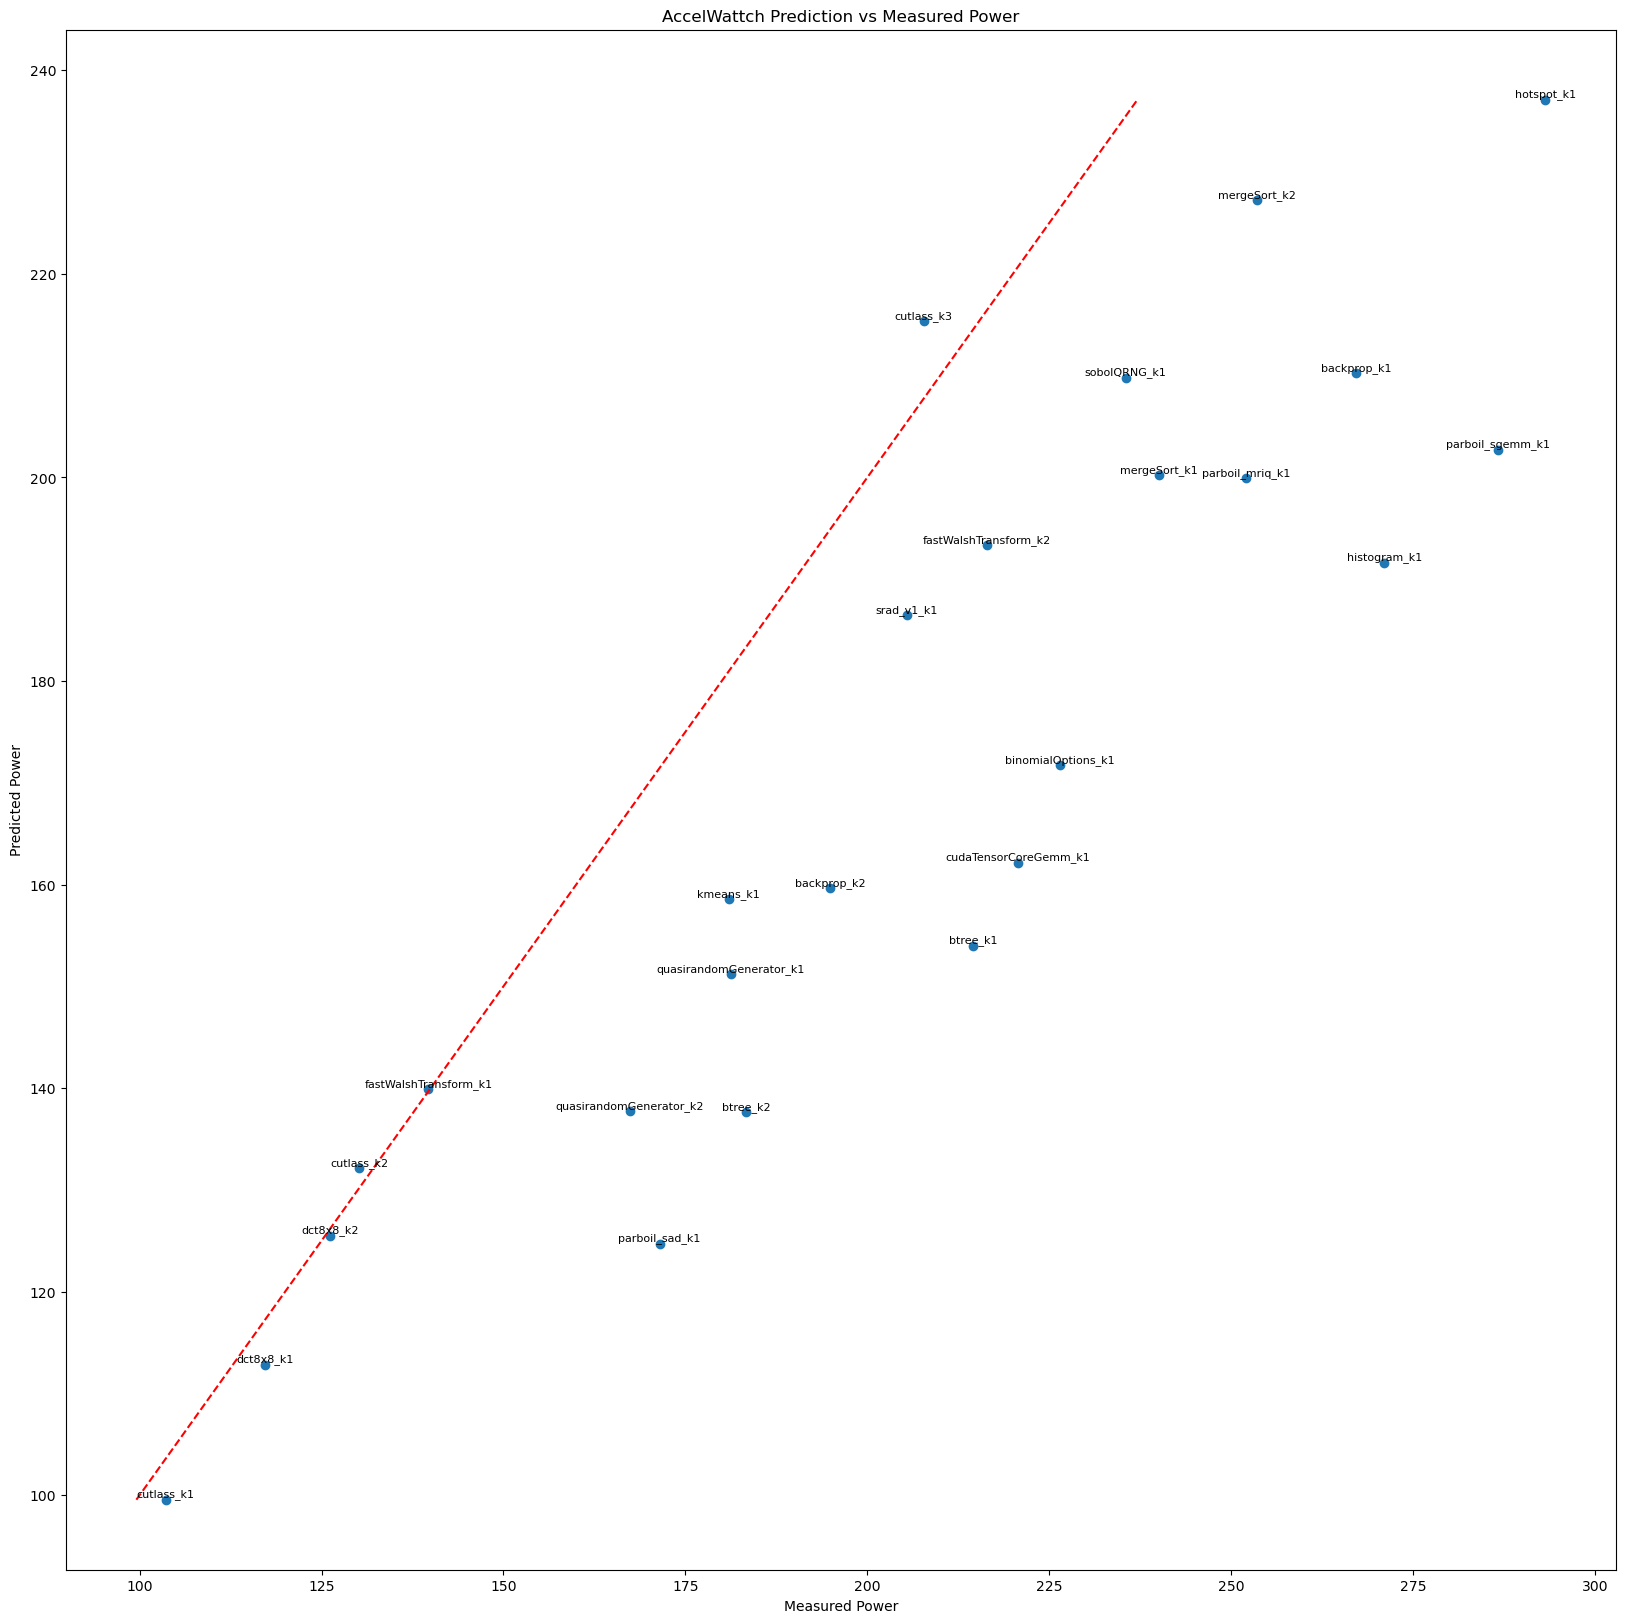

In [8]:
# Convert the values of the columns to floats
qv100_df['kernel_avg_power'] = qv100_df['kernel_avg_power'].astype(float)
qv100_df['pwr_measured_HW_avg'] = qv100_df['pwr_measured_HW_avg'].astype(float)

fig = plt.figure(figsize=(20, 20))
# Create the scatter plot (x,y)
plt.scatter(qv100_df['pwr_measured_HW_avg'], qv100_df['kernel_avg_power'])

# Add the x=y diagonal line
plt.plot([qv100_df['kernel_avg_power'].min(), qv100_df['kernel_avg_power'].max()],
        [qv100_df['kernel_avg_power'].min(), qv100_df['kernel_avg_power'].max()],
        color='red', linestyle='--', label='x=y')

for i, label in enumerate(qv100_df['Kernel Names']):
    plt.text(qv100_df['pwr_measured_HW_avg'][i], qv100_df['kernel_avg_power'][i], label,
            fontsize=8, ha='center', va='bottom')

# Set labels and title
plt.xlabel('Measured Power')
plt.ylabel('Predicted Power')
plt.title('AccelWattch Prediction vs Measured Power')

# Show the plot
plt.show()


In [9]:
# Set the random seed for reproducibility
np.random.seed(42)

# Define the number of bootstrap iterations
num_iterations = 1000  # You can increase this value for more robust results

# Create an empty array to store the MAPE values from each iteration
mape_values = np.empty(num_iterations)

# Perform bootstrapping
for i in range(num_iterations):
    # Sample with replacement from the dataset
    bootstrap_sample = qv100_df.sample(frac=1, replace=True)
    
    # Calculate the absolute percentage error
    bootstrap_sample['Absolute Error'] = abs((bootstrap_sample['pwr_measured_HW_avg'] - bootstrap_sample['kernel_avg_power']) / bootstrap_sample['pwr_measured_HW_avg'])
    
    # Calculate the MAPE for the bootstrap sample
    mape_values[i] = bootstrap_sample['Absolute Error'].mean() * 100

# Calculate the absolute percentage error
qv100_df['Absolute Error'] = abs((qv100_df['pwr_measured_HW_avg'] - qv100_df['kernel_avg_power']) / qv100_df['pwr_measured_HW_avg'])

# Calculate the mean and interval for the MAPE
mean_mape = qv100_df['Absolute Error'].mean() * 100
interval = np.percentile(mape_values, [2.5, 97.5])

# Print the MAPE as mean ± interval
print("MAPE: {:.2f}±{:.2f}%".format(mean_mape, interval[1] - mean_mape))


MAPE: 15.47±3.49%


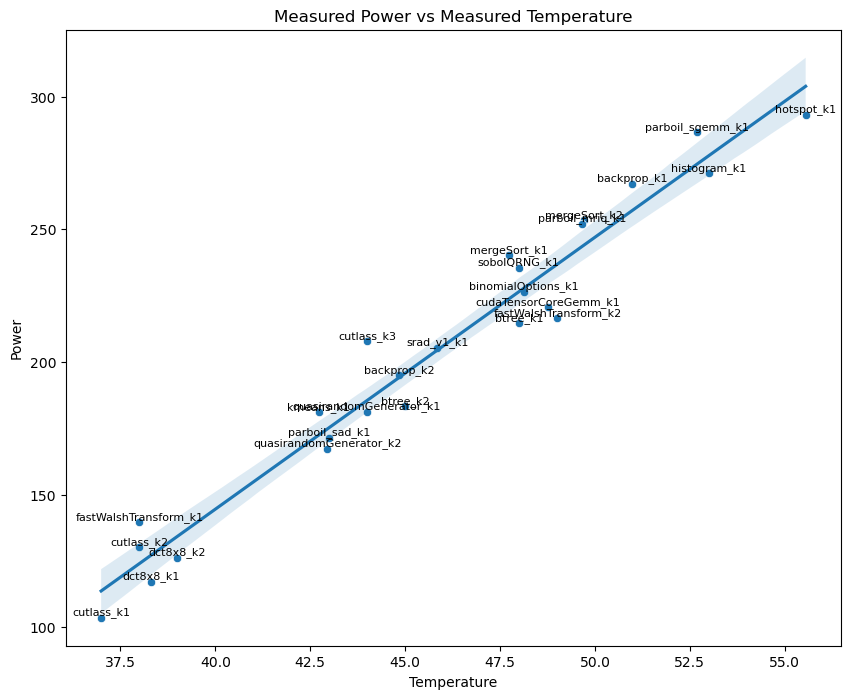

In [10]:
import seaborn as sns
# Convert the values of the columns to floats
qv100_df['tmp_measured_HW_avg'] = qv100_df['tmp_measured_HW_avg'].astype(float)

fig1=plt.figure(figsize=(10,8))

# Create the scatter plot
sns.scatterplot(y='pwr_measured_HW_avg', x='tmp_measured_HW_avg', data=qv100_df)

# Add the regression curve
sns.regplot(y='pwr_measured_HW_avg', x='tmp_measured_HW_avg', data=qv100_df, scatter=False)


for i, label in enumerate(qv100_df['Kernel Names']):
    plt.text( qv100_df['tmp_measured_HW_avg'][i], qv100_df['pwr_measured_HW_avg'][i], label, fontsize=8, ha='center', va='bottom')

# Set labels and title
plt.ylabel('Power')
plt.xlabel('Temperature')
plt.title('Measured Power vs Measured Temperature')

# Show the plot
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
x = qv100_df['tmp_measured_HW_avg']
y = qv100_df['pwr_measured_HW_avg']
coefficients = np.polyfit(x, y, 1)
m, c = coefficients
regression_line = f'y = {m:.2f}x + {c:.2f}'

# Calculate RMSE
y_pred = m * x + c
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate CV
cv = np.std(y) / np.mean(y)

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Print regression line equation, RMSE, CV, and correlation coefficient
print('Regression line:', regression_line)
print('RMSE:', rmse)
print('CV:', cv)
print('Correlation coefficient:', correlation_coefficient)



Regression line: y = 10.25x + -265.52
RMSE: 11.013654583127062
CV: 0.25744138092295976
Correlation coefficient: 0.9776462262850427


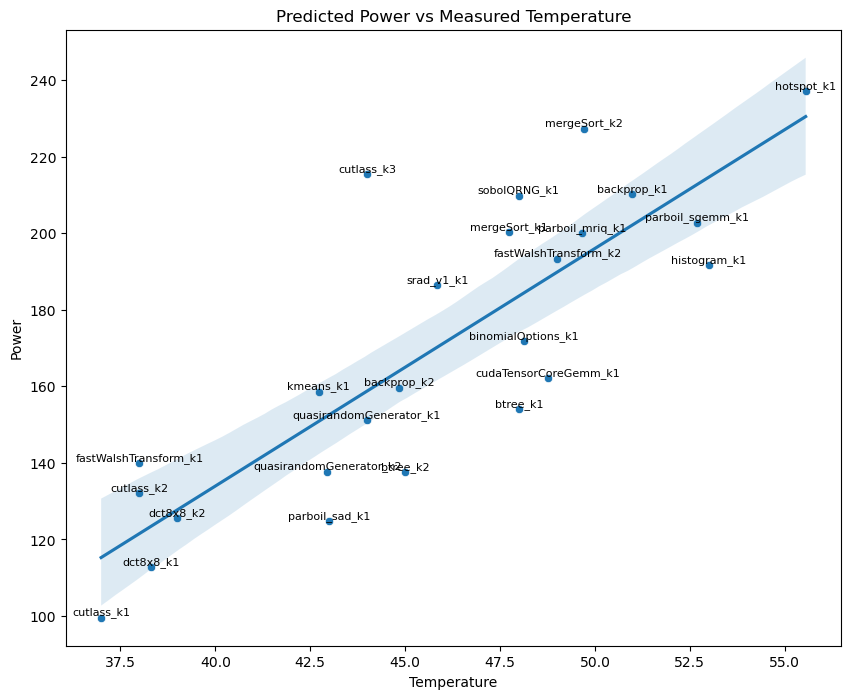

In [12]:
fig2=plt.figure(figsize=(10,8))

# Create the scatter plot
sns.scatterplot(y='kernel_avg_power', x='tmp_measured_HW_avg', data=qv100_df)

# Add the regression curve
sns.regplot(y='kernel_avg_power', x='tmp_measured_HW_avg', data=qv100_df, scatter=False)


for i, label in enumerate(qv100_df['Kernel Names']):
    plt.text(qv100_df['tmp_measured_HW_avg'][i], qv100_df['kernel_avg_power'][i], label, fontsize=8, ha='center', va='bottom')

# Set labels and title
plt.ylabel('Power')
plt.xlabel('Temperature')
plt.title('Predicted Power vs Measured Temperature')

# Show the plot
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
x = qv100_df['tmp_measured_HW_avg']
y = qv100_df['kernel_avg_power']
coefficients = np.polyfit(x, y, 1)
m, c = coefficients
regression_line = f'y = {m:.2f}x + {c:.2f}'

# Calculate RMSE
y_pred = m * x + c
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate CV
cv = np.std(y) / np.mean(y)

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Print regression line equation, RMSE, CV, and correlation coefficient
print('Regression line:', regression_line)
print('RMSE:', rmse)
print('CV:', cv)
print('Correlation coefficient:', correlation_coefficient)


Regression line: y = 6.21x + -114.32
RMSE: 20.753168155070767
CV: 0.21993521476027256
Correlation coefficient: 0.8310492986962135


Text(0.5, 1.0, 'Predicted Power vs Measured Temperature')

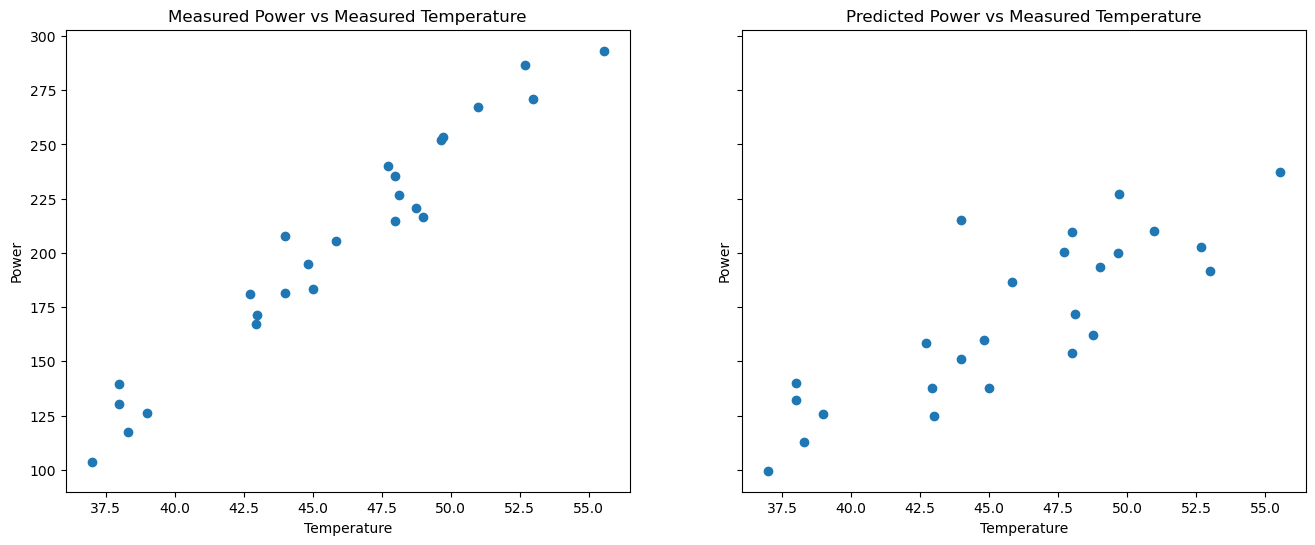

In [14]:
# Create a new figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True)

# Copy the plots from the first figure to the first subplot
axs[0].scatter(*fig1.get_axes()[0].collections[0].get_offsets().T)
axs[0].set_xlabel(fig1.get_axes()[0].get_xlabel())
axs[0].set_ylabel(fig1.get_axes()[0].get_ylabel())
axs[0].set_title(fig1.get_axes()[0].get_title())
axs[1].scatter(*fig2.get_axes()[0].collections[0].get_offsets().T)
axs[1].set_xlabel(fig2.get_axes()[0].get_xlabel())
axs[1].set_ylabel(fig2.get_axes()[0].get_ylabel())
axs[1].set_title(fig2.get_axes()[0].get_title())

0.38593164892109655 7.855242993789389 -221.39627025738028


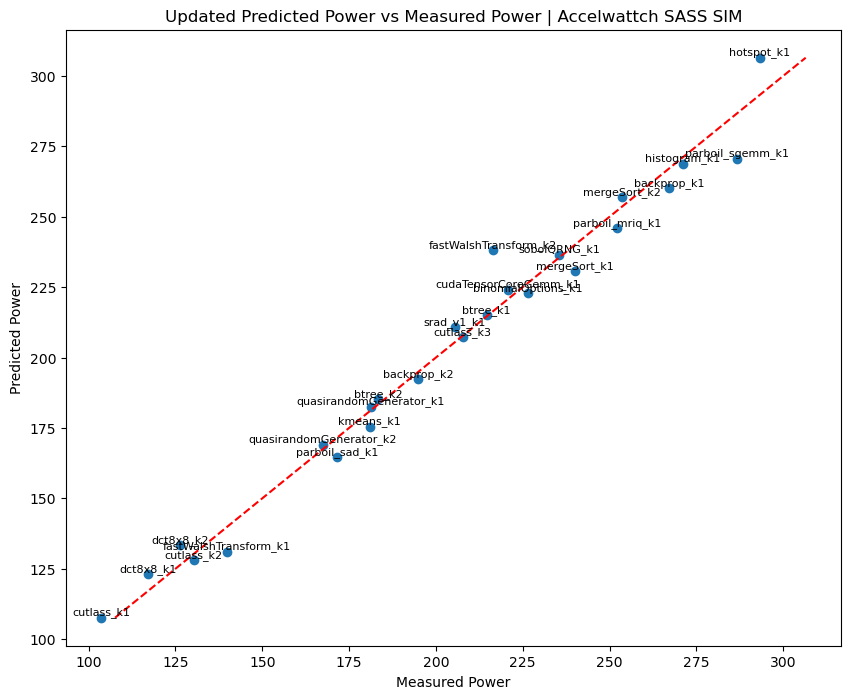

In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression


X = qv100_df[['kernel_avg_power', 'tmp_measured_HW_avg']].values
y = qv100_df['pwr_measured_HW_avg'].values

# Fit the linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Get the coefficients for the features
coefficient_kernel = regression_model.coef_[0]
coefficient_temperature = regression_model.coef_[1]
intercept = regression_model.intercept_
print(coefficient_kernel,coefficient_temperature,intercept)
# Update the power_prediction values based on temperature and kernel power
qv100_df['updated_power_prediction'] = (qv100_df['kernel_avg_power'] * coefficient_kernel) + (qv100_df['tmp_measured_HW_avg'] * coefficient_temperature) + regression_model.intercept_


fig = plt.figure(figsize=(10, 8))
# Create the scatter plot (x,y)
plt.scatter(qv100_df['pwr_measured_HW_avg'], qv100_df['updated_power_prediction'])

# Add the x=y diagonal line
plt.plot([qv100_df['updated_power_prediction'].min(), qv100_df['updated_power_prediction'].max()],
        [qv100_df['updated_power_prediction'].min(), qv100_df['updated_power_prediction'].max()],
        color='red', linestyle='--', label='x=y')

for i, label in enumerate(qv100_df['Kernel Names']):
    plt.text(qv100_df['pwr_measured_HW_avg'][i], qv100_df['updated_power_prediction'][i], label,
            fontsize=8, ha='center', va='bottom')

# Set labels and title
plt.xlabel('Measured Power')
plt.ylabel('Predicted Power')
plt.title('Updated Predicted Power vs Measured Power | Accelwattch SASS SIM')

# Show the plot
plt.show()
# qv100_df['updated_power_prediction']

In [16]:
# Calculate the absolute percentage error
qv100_df['Absolute Error'] = abs((qv100_df['pwr_measured_HW_avg'] - qv100_df['updated_power_prediction']) / qv100_df['pwr_measured_HW_avg'])

# Calculate the mean and interval for the MAPE
mean_mape = qv100_df['Absolute Error'].mean() * 100
interval = np.percentile(mape_values, [2.5, 97.5])

# Print the MAPE as mean
print("MAPE: {:.2f}".format(mean_mape))

MAPE: 2.86


<h1>Recreating AccelWattch Component Graphs</h1>

In [17]:
predicted_df = qv100_df
print(predicted_df.columns)
predicted_df


Index(['index', 'KERNEL_NAME', 'IBP', 'ICP', 'DCP', 'CCP', 'SHRDP', 'RFP',
       'INTP', 'FPUP', 'DPUP', 'INT_MULP', 'FP_MULP', 'FP_SQRTP', 'FP_LGP',
       'FP_SINP', 'FP_EXP', 'DP_MULP', 'TENSORP', 'TEXP', 'SCHEDP', 'L2CP',
       'DRAMP', 'PIPEP', 'IDLE_COREP', 'CONSTP', 'STATICP', 'kernel_avg_power',
       'Kernel Names', 'pwr_measured_HW_avg', 'pwr_st_dev', 'pwr_var',
       'pwr_#samples', 'tmp_measured_HW_avg', 'tmp_st_dev', 'tmp_var',
       'tmp_#samples', 'Absolute Error', 'updated_power_prediction'],
      dtype='object')


,index,KERNEL_NAME,IBP,ICP,DCP,CCP,SHRDP,RFP,INTP,FPUP,...,pwr_measured_HW_avg,pwr_st_dev,pwr_var,pwr_#samples,tmp_measured_HW_avg,tmp_st_dev,tmp_var,tmp_#samples,Absolute Error,updated_power_prediction
0,0,backprop_k1,16.370900,0.0,3.172340,0.000000,15.36370,0.0,2.378310,0.449880,...,267.131297,0.695005,4.830319e-01,5,50.974333,0.074904,5.610667e-03,5,0.026125,260.152371
1,1,backprop_k2,3.764520,0.0,9.746520,0.000000,0.00000,0.0,0.432460,0.324358,...,194.929469,0.185017,3.423125e-02,5,44.834667,0.312452,9.762600e-02,5,0.012913,192.412251
2,2,binomialOptions_k1,16.998200,0.0,0.000214,0.011650,10.63740,0.0,0.913003,0.006877,...,226.460695,0.155956,2.432242e-02,5,48.117667,0.129330,1.672622e-02,5,0.015886,222.863068
3,3,btree_k1,9.914130,0.0,14.395100,0.000000,0.00000,0.0,2.284030,0.000000,...,214.566011,0.374309,1.401075e-01,5,48.000000,0.000000,0.000000e+00,5,0.002401,215.081149
4,4,btree_k2,8.671410,0.0,9.795910,0.000000,0.00000,0.0,1.924540,0.000000,...,183.321799,0.179043,3.205647e-02,5,45.000000,0.000000,0.000000e+00,5,0.010271,185.204665
5,9,dct8x8_k1,2.360310,0.0,0.379709,21.829100,4.10388,0.0,0.315241,0.048500,...,117.231463,0.266584,7.106710e-02,5,38.310667,0.246168,6.059844e-02,5,0.049901,123.081433
6,10,dct8x8_k2,3.589960,0.0,3.272950,0.000000,7.31190,0.0,0.819096,0.176426,...,126.228123,0.480088,2.304849e-01,5,39.000000,0.000000,0.000000e+00,5,0.056752,133.391857
7,11,fastWalshTransform_k1,2.074050,0.0,3.428320,0.000000,0.00000,0.0,0.465941,0.155318,...,139.695096,0.477538,2.280426e-01,5,37.999667,0.000667,4.444444e-07,5,0.061658,131.081763
8,12,fastWalshTransform_k2,10.404100,0.0,2.996870,0.000000,19.74750,0.0,2.953040,0.691159,...,216.421677,0.046736,2.184251e-03,5,49.008333,0.016667,2.777778e-04,5,0.100630,238.200226
9,13,histogram_k1,8.783590,0.0,4.306680,0.000000,28.93860,0.0,4.206400,0.000000,...,271.064172,0.122042,1.489433e-02,5,52.990333,0.069101,4.774889e-03,5,0.008339,268.803652


In [18]:
def aggregate_predicted_values(predicted_df):
    predicted_df['ALUP']=predicted_df['INTP']+predicted_df['INT_MULP']
    predicted_df['FPU_DPUP']=predicted_df['FPUP']+predicted_df['FP_MULP']+predicted_df['DPUP']+predicted_df['DP_MULP']
    predicted_df['SFUP']=predicted_df['FP_SQRTP']+predicted_df['FP_LGP']+predicted_df['FP_SINP']+predicted_df['FP_EXP']
    predicted_df['L1D_SHRDP']=predicted_df['DCP']+predicted_df['SHRDP']
    predicted_df['ICACHE_CCACHEP']=predicted_df['ICP']+predicted_df['CCP']
    predicted_df['L2_NOCP']=predicted_df['L2CP']
    predicted_df['DRAM_MCP']=predicted_df['DRAMP']
    predicted_df['OTHERP']=predicted_df['IBP']+predicted_df['TEXP']+predicted_df['SCHEDP']+predicted_df['PIPEP']
    return predicted_df

In [19]:
#Just double check that kernel_avg_power matches up to the sums
predicted_df = qv100_df
predicted_power_string='IBP DCP CCP SHRDP INTP FPUP DPUP INT_MULP FP_MULP FP_SQRTP FP_LGP FP_SINP FP_EXP DP_MULP TENSORP TEXP SCHEDP L2CP DRAMP PIPEP IDLE_COREP CONSTP STATICP'
predicted_power_keys = predicted_power_string.split()
predicted_df[predicted_power_keys]
# Sum values of subset columns for each row
sim_total = predicted_df[predicted_power_keys].sum(axis=1)

predicted_df = aggregate_predicted_values(predicted_df)



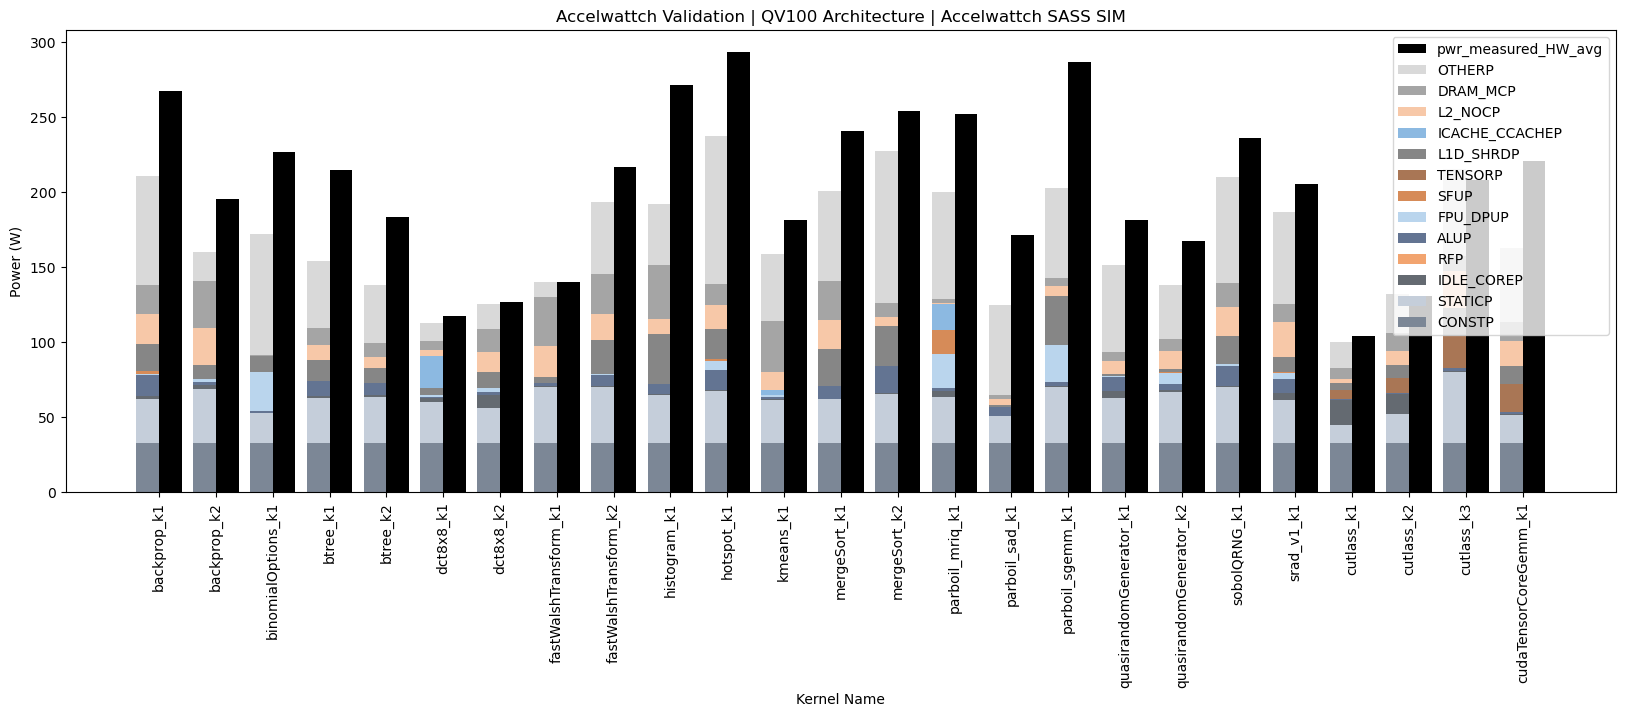

In [20]:

measured_column= 'pwr_measured_HW_avg'

# Set the x-axis labels
x_labels = predicted_df['KERNEL_NAME']

# Set the values for each stacked column
stack_values = predicted_df[stack_columns].values.T
x_axis = np.arange(len(stack_values[0]))
stack_values[0],x_axis
bar_width=0.4
bar_offset=0.2

# Plot the stacked bar graph
plt.figure(figsize=(20, 6))
plt.bar(x_axis-bar_offset, stack_values[0],width=bar_width, label=stack_columns[0],color=custom_colors[0])
for i in range(1, len(stack_columns)):
    plt.bar(x_axis-bar_offset, 
            stack_values[i], width=bar_width, 
            bottom=stack_values[:i].sum(axis=0), 
            label=stack_columns[i], 
            color=custom_colors[i%len(custom_colors)])

plt.bar(x_axis+bar_offset,predicted_df[measured_column],width=bar_width,label=measured_column,color='black')
# # Rotate the x-labels by 90 degrees
plt.xticks(x_axis,x_labels,rotation=90)

# Add labels and title
plt.xlabel('Kernel Name')
plt.ylabel('Power (W)')
plt.title('Accelwattch Validation | QV100 Architecture | Accelwattch SASS SIM')

# Add legend
# Reverse the order of handles and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

# Add legend with reversed order
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1),markerscale=10)
# # Show the plot
plt.show()


In [21]:
#Getting the columns into graph form



In [22]:
np.arange(5,)

array([0, 1, 2, 3, 4])

<h1> Get GPU_Microbenchmark prediction </h1>

In [23]:
gpu_ubench_df = aggregate_predicted_values(get_data("GPU"))
gpu_ubench_df

,index,KERNEL_NAME,IBP,ICP,DCP,TCP,CCP,SHRDP,RFP,INTP,...,STATICP,kernel_avg_power,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
0,0,MaxFlops_k1,0.012587,0.195084,0.002802,0.0,0.0,0.000000,0.643166,0.004307,...,0.454471,56.8554,0.004744,0.232169,0.0,0.002802,0.195084,0.002900,0.555967,0.082680
1,1,l1_bw_128_k1,0.019575,0.257166,2.444920,0.0,0.0,0.000000,0.699928,0.342953,...,0.477761,60.3038,0.354997,0.430722,0.0,2.444920,0.257166,0.001090,0.846440,0.122534
2,2,l1_bw_32f_20xiters_k1,0.159445,0.000000,1.089770,0.0,0.0,0.000000,0.000000,0.044773,...,0.482751,57.7747,0.071160,0.020337,0.0,1.089770,0.000000,0.001818,0.681259,0.761850
3,3,l1_bw_32f_k1,0.019284,0.285894,1.757900,0.0,0.0,0.000000,0.590280,0.239954,...,0.426110,59.2371,0.267402,0.311779,0.0,1.757900,0.285894,0.016894,0.763528,0.122940
4,4,l1_bw_32f_unroll_k1,0.019861,0.273372,0.857197,0.0,0.0,0.000000,0.681413,0.351571,...,0.454867,58.3527,0.465548,0.151758,0.0,0.857197,0.273372,0.007995,0.653832,0.127006
5,5,l1_bw_32f_unroll_large_k1,0.011595,0.165141,1.595840,0.0,0.0,0.000000,0.387373,0.018101,...,0.469496,58.5376,0.022291,0.294195,0.0,1.595840,0.165141,0.105182,0.749768,0.075884
6,6,l1_bw_64f_k1,0.012089,0.227719,1.642940,0.0,0.0,0.000000,0.394647,0.149212,...,0.418977,58.6509,0.212430,0.213438,0.0,1.642940,0.227719,0.017813,0.754676,0.075787
7,7,l1_lat_k1,0.000368,0.004809,0.021046,0.0,0.0,0.000000,0.007942,0.000053,...,0.416679,55.6775,0.000077,0.000000,0.0,0.021046,0.004809,0.001918,0.556524,0.001438
8,8,l1_shared_bw_k1,0.017212,0.221576,0.522439,0.0,0.0,0.025994,0.461610,0.077227,...,0.415708,57.2780,0.241477,0.000000,0.0,0.548433,0.221576,0.000279,0.611786,0.109687
9,9,l2_bw_32f_k1,0.165316,2.272680,0.021117,0.0,0.0,0.000000,8.003790,0.217277,...,38.271100,100.1360,0.223780,4.271060,0.0,0.021117,2.272680,12.909240,0.560152,1.081463


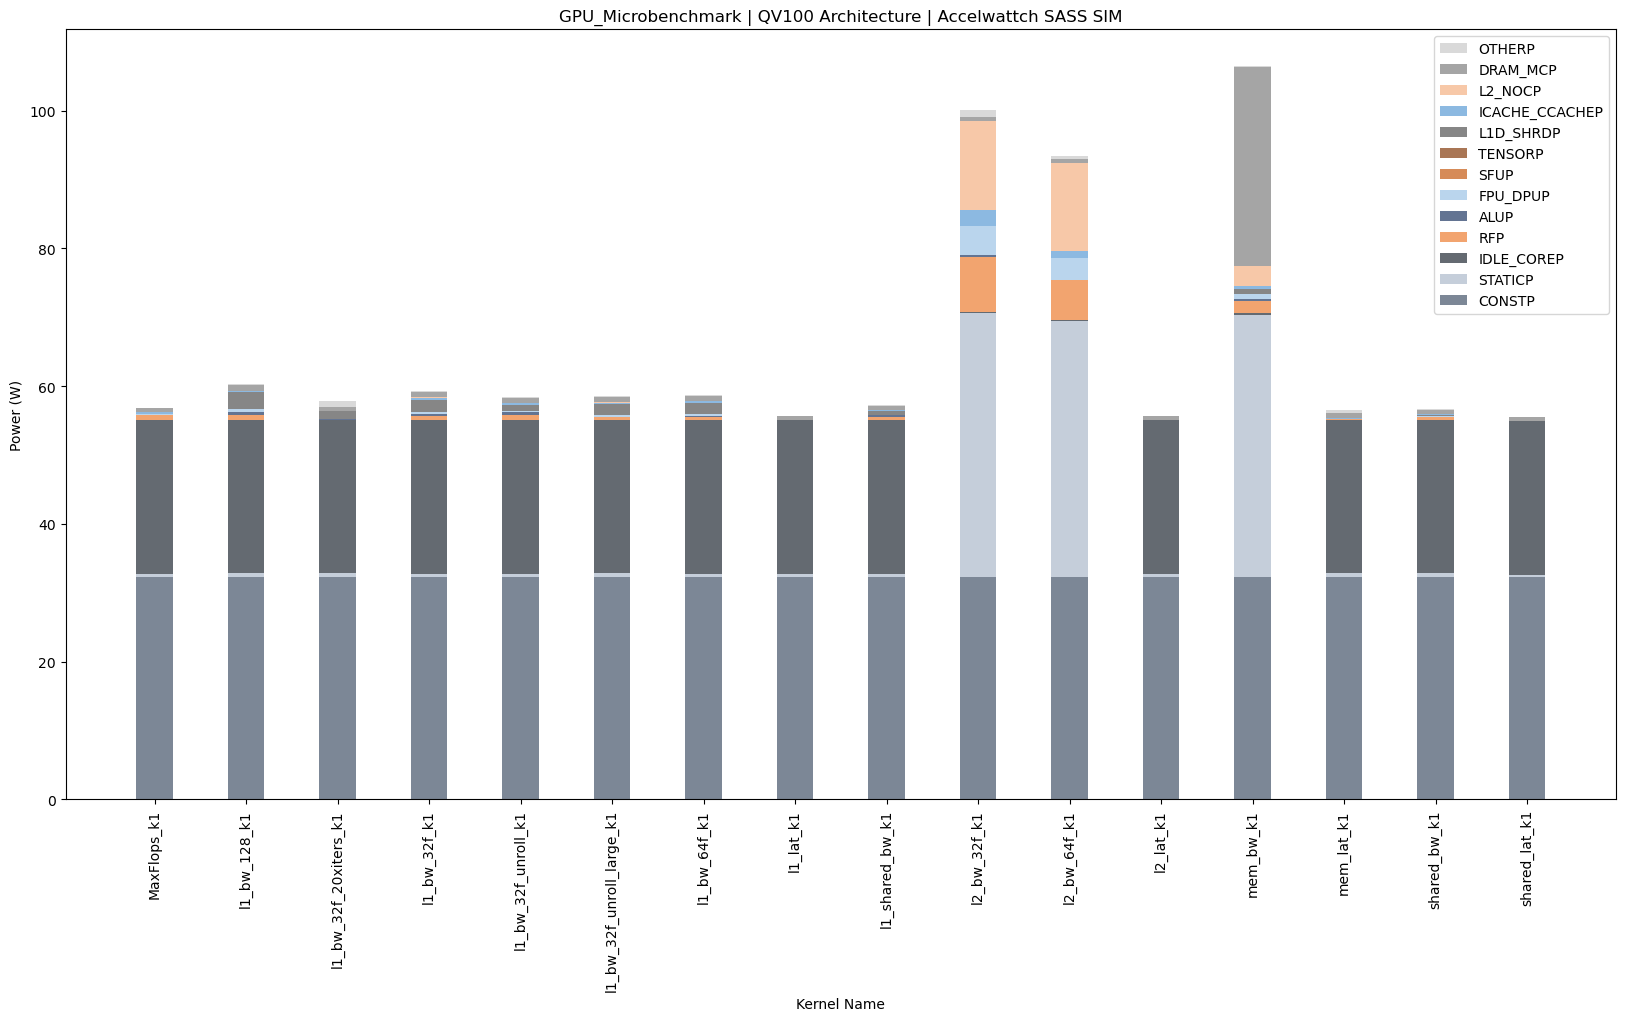

In [24]:

# Set the x-axis labels
x_labels = gpu_ubench_df['KERNEL_NAME']

# Set the values for each stacked column
stack_values = gpu_ubench_df[stack_columns].values.T
x_axis = np.arange(len(stack_values[0]))
stack_values[0],x_axis
bar_width=0.4
bar_offset=0

# Plot the stacked bar graph
plt.figure(figsize=(20, 10))
plt.bar(x_axis-bar_offset, stack_values[0],width=bar_width, label=stack_columns[0],color=custom_colors[0])
for i in range(1, len(stack_columns)):
    plt.bar(x_axis-bar_offset, 
            stack_values[i], width=bar_width, 
            bottom=stack_values[:i].sum(axis=0), 
            label=stack_columns[i], 
            color=custom_colors[i%len(custom_colors)])
# # Rotate the x-labels by 90 degrees
plt.xticks(x_axis,x_labels,rotation=90)

# Add labels and title
plt.xlabel('Kernel Name')
plt.ylabel('Power (W)')
plt.title('GPU_Microbenchmark | QV100 Architecture | Accelwattch SASS SIM')

# Add legend
# Reverse the order of handles and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

# Add legend with reversed order
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1),markerscale=10)
# # Show the plot
plt.show()


In [25]:
print(gpu_ubench_df.index)
gpu_ubench_df[gpu_ubench_df['KERNEL_NAME'].isin(['l1_bw_32f_20xiters_k1','l1_bw_32f_k1'])].T

RangeIndex(start=0, stop=16, step=1)


,2,3
index,2,3
KERNEL_NAME,l1_bw_32f_20xiters_k1,l1_bw_32f_k1
IBP,0.159445,0.019284
ICP,0.0,0.285894
DCP,1.08977,1.7579
TCP,0.0,0.0
CCP,0.0,0.0
SHRDP,0.0,0.0
RFP,0.0,0.59028
INTP,0.044773,0.239954


<h1>Show me Tesla Config <i>(NOTE THIS IS ONLY USING THE TESLAV100 gpgpusim.config)</i></h1>

In [26]:
tesla_config_df = aggregate_predicted_values(get_data("TeslaV100_tuner_only"))
tesla_config_df


,index,KERNEL_NAME,IBP,ICP,DCP,CCP,SHRDP,RFP,INTP,FPUP,...,tmp_var,tmp_#samples,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
0,0,backprop_k1,14.843600,0.0,2.876370,0.000000,13.93030,0.0,2.668270,0.407907,...,5.610667e-03,5,14.609770,0.745189,1.349110,16.806670,0.000000,17.806060,17.935290,65.366500
1,1,backprop_k2,3.413310,0.0,8.837200,0.000000,0.00000,0.0,0.424418,0.294097,...,9.762600e-02,5,1.873358,1.804918,0.000000,8.837200,0.000000,22.155200,28.095030,17.658740
2,2,binomialOptions_k1,15.412300,0.0,0.000194,0.010563,9.64498,0.0,0.840289,0.006235,...,1.672622e-02,5,0.841090,25.565135,0.011636,9.645174,0.010563,0.001182,0.552459,73.045200
3,3,btree_k1,8.989180,0.0,13.052100,0.000000,0.00000,0.0,2.166350,0.000000,...,0.000000e+00,5,9.255860,0.000000,0.000000,13.052100,0.000000,8.597800,10.806440,40.327910
4,4,btree_k2,7.862400,0.0,8.881990,0.000000,0.00000,0.0,1.825520,0.000000,...,0.000000e+00,5,7.964010,0.000000,0.000000,8.881990,0.000000,6.509810,8.626040,34.863940
5,6,dct8x8_k1,2.140100,0.0,0.344283,19.792500,3.72100,0.0,0.296698,0.043975,...,6.059844e-02,5,0.702929,1.343895,0.000000,4.065283,19.792500,3.155240,5.768920,11.093430
6,7,dct8x8_k2,3.255030,0.0,2.967590,0.000000,6.62973,0.0,0.748325,0.159966,...,0.000000e+00,5,1.339414,2.524286,0.000000,9.597320,0.000000,12.426430,13.716530,15.491420
7,8,fastWalshTransform_k1,1.880550,0.0,3.108470,0.000000,0.00000,0.0,0.439873,0.140828,...,4.444444e-07,5,2.000983,0.140828,0.000000,3.108470,0.000000,19.144500,29.767130,8.870630
8,9,fastWalshTransform_k2,9.433390,0.0,2.717270,0.000000,17.90520,0.0,2.691610,0.626677,...,2.777778e-04,5,6.586070,0.626677,0.000000,20.622470,0.000000,15.489490,24.333950,43.877190
9,10,histogram_k1,7.964110,0.0,3.904880,0.000000,26.23870,0.0,3.815870,0.000000,...,4.774889e-03,5,5.864030,0.000000,0.000000,30.143580,0.000000,9.406005,32.601980,36.574460


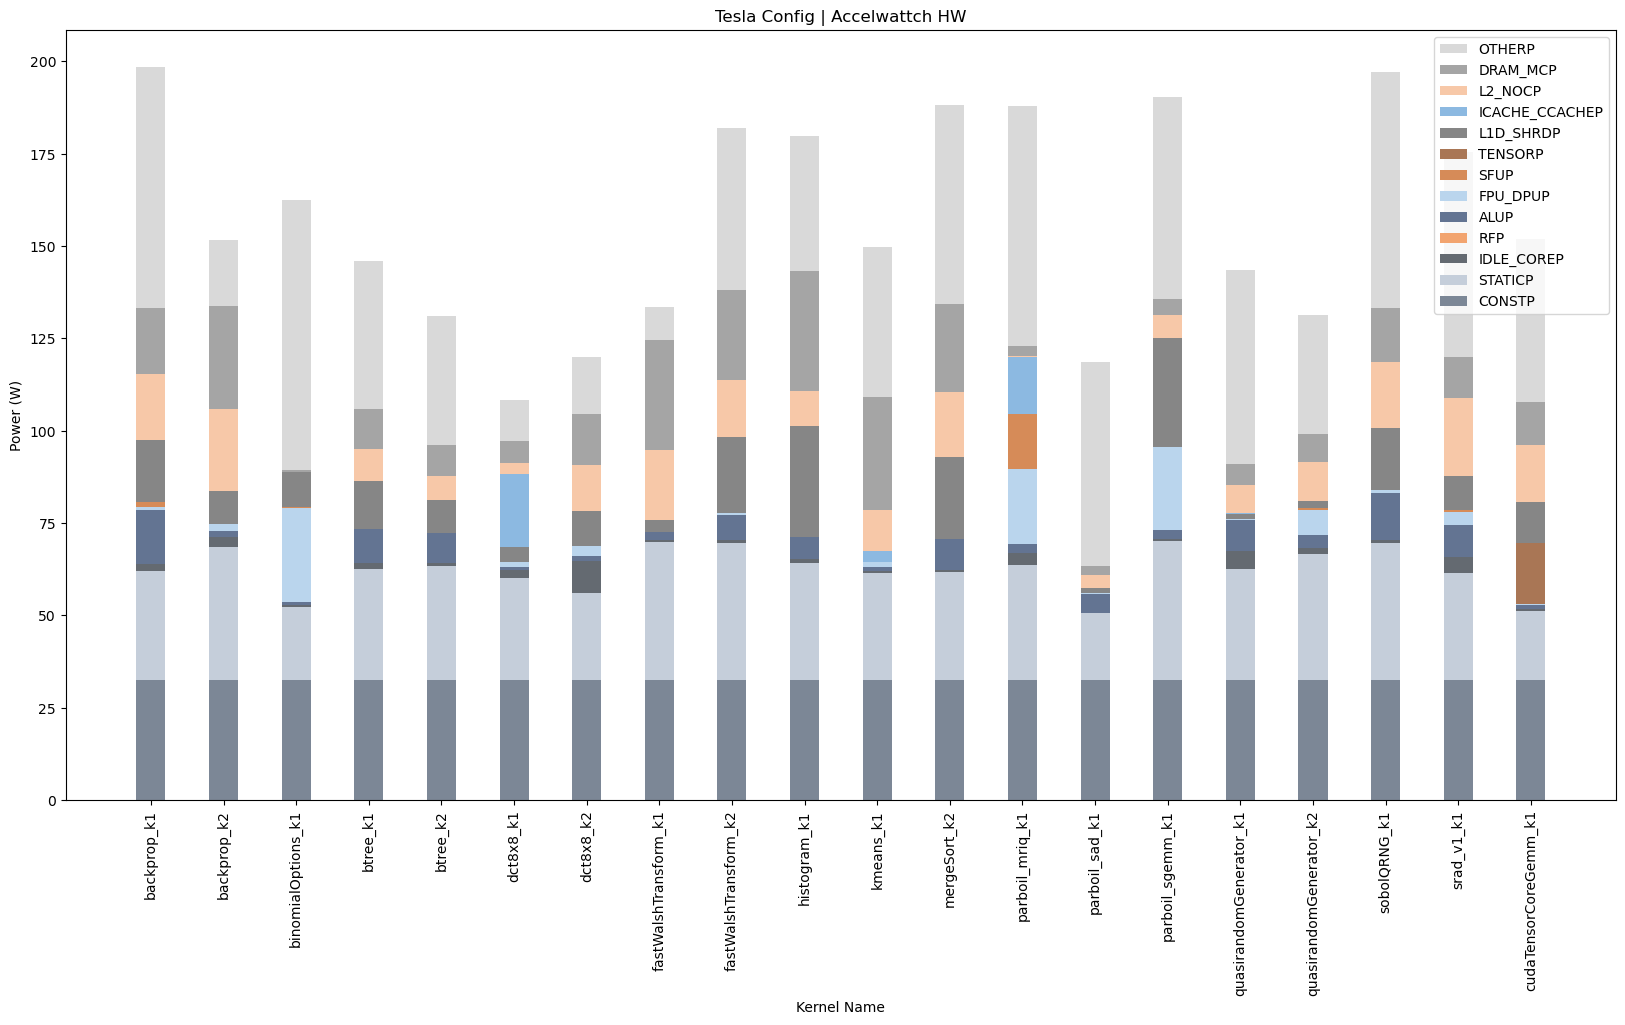

In [27]:
# Set the x-axis labels
x_labels = tesla_config_df['KERNEL_NAME']

# Set the values for each stacked column
stack_values = tesla_config_df[stack_columns].values.T
x_axis = np.arange(len(stack_values[0]))
stack_values[0],x_axis
bar_width=0.4
bar_offset=0

# Plot the stacked bar graph
plt.figure(figsize=(20, 10))
plt.bar(x_axis-bar_offset, stack_values[0],width=bar_width, label=stack_columns[0],color=custom_colors[0])
for i in range(1, len(stack_columns)):
    plt.bar(x_axis-bar_offset, 
            stack_values[i], width=bar_width, 
            bottom=stack_values[:i].sum(axis=0), 
            label=stack_columns[i], 
            color=custom_colors[i%len(custom_colors)])
# # Rotate the x-labels by 90 degrees
plt.xticks(x_axis,x_labels,rotation=90)

# Add labels and title
plt.xlabel('Kernel Name')
plt.ylabel('Power (W)')
plt.title('Tesla Config | Accelwattch HW')

# Add legend
# Reverse the order of handles and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

# Add legend with reversed order
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1),markerscale=10)
# # Show the plot
plt.show()

0.3605429377558875 8.251042532269386 -235.10435117547095


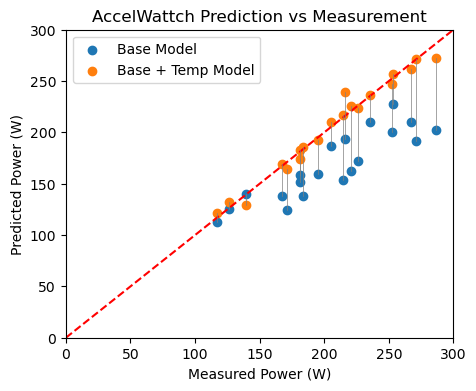

In [65]:
top = 300
bot = 0
#since the tesla_config is incomplete, we need to remove the qv100 rows
new_qv100_df = qv100_df[qv100_df['KERNEL_NAME'].isin(tesla_config_df['KERNEL_NAME'])].reset_index()

tesla_config_df['KERNEL_NAME'],new_qv100_df['KERNEL_NAME']
#Now let's compare the QV100 scatterplot with this plot
# Convert the values of the columns to floats
tesla_config_df['kernel_avg_power'] = tesla_config_df['kernel_avg_power'].astype(float)
tesla_config_df['pwr_measured_HW_avg'] = tesla_config_df['pwr_measured_HW_avg'].astype(float)

# Fit the linear regression model
X = new_qv100_df[['kernel_avg_power', 'tmp_measured_HW_avg']].values
y = new_qv100_df['pwr_measured_HW_avg'].values
regression_model = LinearRegression()
regression_model.fit(X, y)

# Get the coefficients for the features
coefficient_kernel = regression_model.coef_[0]
coefficient_temperature = regression_model.coef_[1]
intercept = regression_model.intercept_
print(coefficient_kernel,coefficient_temperature,intercept)
# Update the power_prediction values based on temperature and kernel power
new_qv100_df['updated_power_prediction'] = (new_qv100_df['kernel_avg_power'] * coefficient_kernel) + (new_qv100_df['tmp_measured_HW_avg'] * coefficient_temperature) + regression_model.intercept_

fig = plt.figure(figsize=(5,4))
# Create the qv100 scatter plot (x,y)
plt.scatter(new_qv100_df['pwr_measured_HW_avg'], new_qv100_df['kernel_avg_power'],label='Base Model')

# # Create the qv100 scatter plot (x,y)
# plt.scatter(tesla_config_df['pwr_measured_HW_avg'], tesla_config_df['kernel_avg_power'],label='Tuned Model')


# Create the temperature corrected scatter plot
plt.scatter(new_qv100_df['pwr_measured_HW_avg'], new_qv100_df['updated_power_prediction'], label="Base + Temp Model")


# Add the x=y diagonal line
plt.plot(range(bot,top),range(bot,top),
         color='red', linestyle='--')

# for i, label in enumerate(tesla_incomplete_df['Kernel Names']):
#     plt.text(tesla_incomplete_df['pwr_measured_HW_avg'][i], tesla_incomplete_df['kernel_avg_power'][i], "T"+label[:5],
#              fontsize=8, ha='center', va='bottom')

# for i, label in enumerate(new_qv100_df['Kernel Names']):
#     plt.text(new_qv100_df['pwr_measured_HW_avg'][i], new_qv100_df['kernel_avg_power'][i], "Q"+label[:5],
#             fontsize=8, ha='center', va='bottom')


# Connect related points with lines
for idx, row in new_qv100_df.iterrows():
    matching_row = new_qv100_df[new_qv100_df['Kernel Names'] == row['Kernel Names']]
    if not matching_row.empty:
        plt.plot([row['pwr_measured_HW_avg'], matching_row['pwr_measured_HW_avg'].values[0]],
                 [row['kernel_avg_power'], matching_row['updated_power_prediction'].values[0]],
                 color='gray', linestyle='-', linewidth=0.5)

# Set labels and title
plt.ylim(bot,top)
plt.xlim(bot,top)
plt.xlabel('Measured Power (W)')
plt.ylabel('Predicted Power (W)')
plt.title('AccelWattch Prediction vs Measurement')

# Show the legend
plt.legend()
# plt.savefig('accelwattch_summit.pdf')
# Show the plot
plt.show()


In [29]:
new_qv100_df['KERNEL_NAME'],tesla_config_df['KERNEL_NAME']

(0                 backprop_k1
 1                 backprop_k2
 2          binomialOptions_k1
 3                    btree_k1
 4                    btree_k2
 5                   dct8x8_k1
 6                   dct8x8_k2
 7       fastWalshTransform_k1
 8       fastWalshTransform_k2
 9                histogram_k1
 10                  kmeans_k1
 11               mergeSort_k2
 12            parboil_mriq_k1
 13             parboil_sad_k1
 14           parboil_sgemm_k1
 15    quasirandomGenerator_k1
 16    quasirandomGenerator_k2
 17               sobolQRNG_k1
 18                 srad_v1_k1
 19      cudaTensorCoreGemm_k1
 Name: KERNEL_NAME, dtype: object,
 0                 backprop_k1
 1                 backprop_k2
 2          binomialOptions_k1
 3                    btree_k1
 4                    btree_k2
 5                   dct8x8_k1
 6                   dct8x8_k2
 7       fastWalshTransform_k1
 8       fastWalshTransform_k2
 9                histogram_k1
 10                  kmeans_k1
 11 

In [30]:
#Trying to use my compiled trace for parboil-mri-q segfaults so I want to figure out the difference in config alone

compare_df = pd.concat([tesla_config_df[tesla_config_df.KERNEL_NAME == 'parboil-mri-q_k1'],qv100_df[qv100_df.KERNEL_NAME == 'parboil-mri-q_k1']],axis=0).dropna(axis=1)
compare_df

,index,KERNEL_NAME,IBP,ICP,DCP,CCP,SHRDP,RFP,INTP,FPUP,...,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP,Absolute Error,updated_power_prediction


In [31]:
tesla_config_df

,index,KERNEL_NAME,IBP,ICP,DCP,CCP,SHRDP,RFP,INTP,FPUP,...,tmp_var,tmp_#samples,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
0,0,backprop_k1,14.843600,0.0,2.876370,0.000000,13.93030,0.0,2.668270,0.407907,...,5.610667e-03,5,14.609770,0.745189,1.349110,16.806670,0.000000,17.806060,17.935290,65.366500
1,1,backprop_k2,3.413310,0.0,8.837200,0.000000,0.00000,0.0,0.424418,0.294097,...,9.762600e-02,5,1.873358,1.804918,0.000000,8.837200,0.000000,22.155200,28.095030,17.658740
2,2,binomialOptions_k1,15.412300,0.0,0.000194,0.010563,9.64498,0.0,0.840289,0.006235,...,1.672622e-02,5,0.841090,25.565135,0.011636,9.645174,0.010563,0.001182,0.552459,73.045200
3,3,btree_k1,8.989180,0.0,13.052100,0.000000,0.00000,0.0,2.166350,0.000000,...,0.000000e+00,5,9.255860,0.000000,0.000000,13.052100,0.000000,8.597800,10.806440,40.327910
4,4,btree_k2,7.862400,0.0,8.881990,0.000000,0.00000,0.0,1.825520,0.000000,...,0.000000e+00,5,7.964010,0.000000,0.000000,8.881990,0.000000,6.509810,8.626040,34.863940
5,6,dct8x8_k1,2.140100,0.0,0.344283,19.792500,3.72100,0.0,0.296698,0.043975,...,6.059844e-02,5,0.702929,1.343895,0.000000,4.065283,19.792500,3.155240,5.768920,11.093430
6,7,dct8x8_k2,3.255030,0.0,2.967590,0.000000,6.62973,0.0,0.748325,0.159966,...,0.000000e+00,5,1.339414,2.524286,0.000000,9.597320,0.000000,12.426430,13.716530,15.491420
7,8,fastWalshTransform_k1,1.880550,0.0,3.108470,0.000000,0.00000,0.0,0.439873,0.140828,...,4.444444e-07,5,2.000983,0.140828,0.000000,3.108470,0.000000,19.144500,29.767130,8.870630
8,9,fastWalshTransform_k2,9.433390,0.0,2.717270,0.000000,17.90520,0.0,2.691610,0.626677,...,2.777778e-04,5,6.586070,0.626677,0.000000,20.622470,0.000000,15.489490,24.333950,43.877190
9,10,histogram_k1,7.964110,0.0,3.904880,0.000000,26.23870,0.0,3.815870,0.000000,...,4.774889e-03,5,5.864030,0.000000,0.000000,30.143580,0.000000,9.406005,32.601980,36.574460


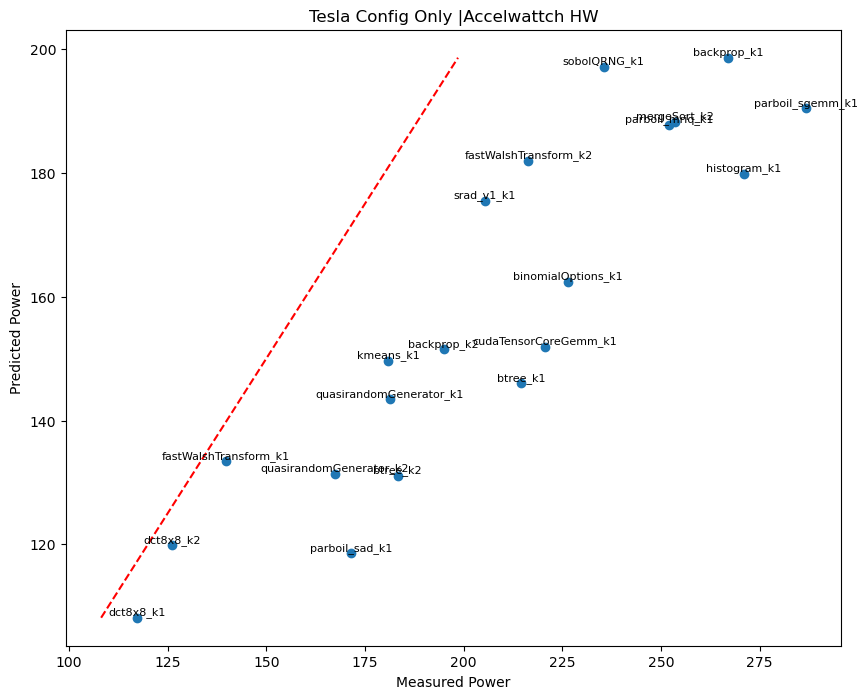

In [32]:
# Convert the values of the columns to floats
tesla_config_df['kernel_avg_power'] = tesla_config_df['kernel_avg_power'].astype(float)
tesla_config_df['pwr_measured_HW_avg'] = tesla_config_df['pwr_measured_HW_avg'].astype(float)

# Fit the linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Get the coefficients for the features
coefficient_kernel = regression_model.coef_[0]
coefficient_temperature = regression_model.coef_[1]
intercept = regression_model.intercept_
print(coefficient_kernel,coefficient_temperature,intercept)
# Update the power_prediction values based on temperature and kernel power
tesla_incomplete_df['updated_power_prediction'] = (tesla_incomplete_df['kernel_avg_power'] * coefficient_kernel) + (tesla_incomplete_df['tmp_measured_HW_avg'] * coefficient_temperature) + regression_model.intercept_




fig = plt.figure(figsize=(10, 8))
# Create the scatter plot (x,y)
plt.scatter(tesla_config_df['pwr_measured_HW_avg'], tesla_config_df['kernel_avg_power'])

# Add the x=y diagonal line
plt.plot([tesla_config_df['kernel_avg_power'].min(), tesla_config_df['kernel_avg_power'].max()],
        [tesla_config_df['kernel_avg_power'].min(), tesla_config_df['kernel_avg_power'].max()],
        color='red', linestyle='--', label='x=y')

for i, label in enumerate(tesla_config_df['Kernel Names']):
    plt.text(tesla_config_df['pwr_measured_HW_avg'][i], tesla_config_df['kernel_avg_power'][i], label,
            fontsize=8, ha='center', va='bottom')

# Set labels and title
plt.xlabel('Measured Power')
plt.ylabel('Predicted Power')
plt.title('Tesla Config Only |Accelwattch HW')

# Show the plot
plt.show()

<h1>INCOMPLETE TeslaV100 data (Issue with LDC insts in traces)</h1>

In [33]:
tesla_incomplete_df = aggregate_predicted_values(get_data("TeslaV100_BadLDC-Accelwattch_SASS_SIM"))
# Set the x-axis labels
x_labels = tesla_incomplete_df['KERNEL_NAME']

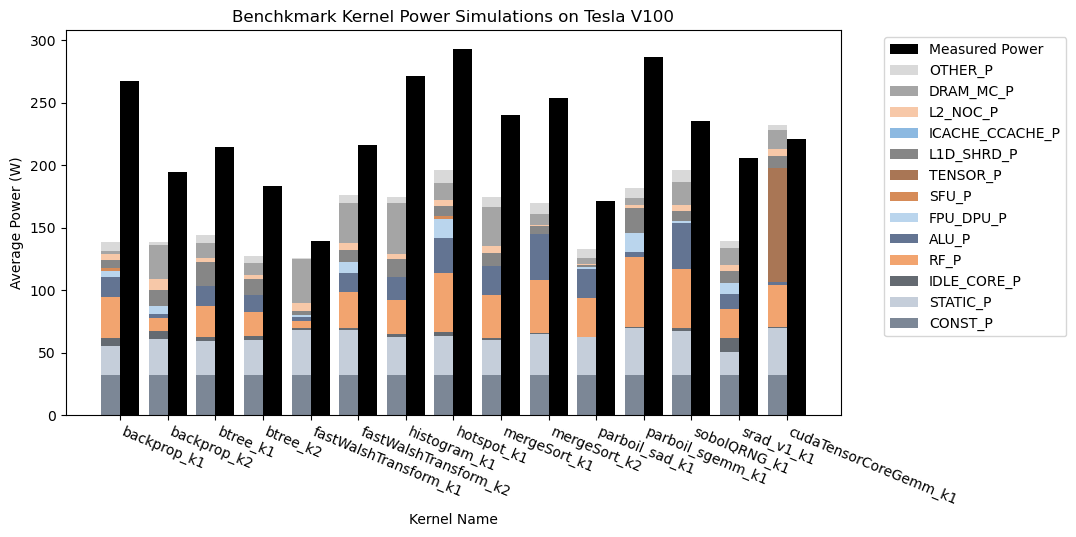

In [34]:
#Make a standalone plot
# Set the x-axis labels
x_labels = tesla_incomplete_df['KERNEL_NAME']

# Set the values for each stacked column
stack_values = tesla_incomplete_df[stack_columns].values.T
x_axis = np.arange(len(stack_values[0]))
stack_values[0],x_axis
bar_width=0.4
bar_offset=0.2

# Plot the stacked bar graph
plt.figure(figsize=(10, 5))
plt.bar(x_axis-bar_offset, stack_values[0],width=bar_width, label=stack_columns[0],color=custom_colors[0])
for i in range(1, len(stack_columns)):
    plt.bar(x_axis-bar_offset, 
            stack_values[i], width=bar_width, 
            bottom=stack_values[:i].sum(axis=0), 
            label=stack_columns[i], 
            color=custom_colors[i%len(custom_colors)])
# Rotate the x-labels by 45 degrees and align them to the right
plt.xticks(x_axis, x_labels, rotation=-22.5, ha='left')

plt.bar(x_axis+bar_offset,tesla_incomplete_df[measured_column],width=bar_width,label=measured_column,color='black')


# Add labels and title
plt.xlabel('Kernel Name')
plt.ylabel('Average Power (W)')
plt.title('Benchkmark Kernel Power Simulations on Tesla V100')

# Add legend
# Reverse the order of handles and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
labels[0]="Measured Power"
labels=[label[:-1]+'_P' if label[-1]=='P' else label for label in labels]
# Add legend with reversed order
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.3,1),markerscale=10)
# # Show the plot
plt.show()

In [35]:
#since the tesla_config is incomplete, we need to remove the qv100 rows
new_qv100_df = qv100_df[qv100_df['KERNEL_NAME'].isin(tesla_incomplete_df['KERNEL_NAME'])].reset_index()

tesla_incomplete_df['KERNEL_NAME'],new_qv100_df['KERNEL_NAME']


(0               backprop_k1
 1               backprop_k2
 2                  btree_k1
 3                  btree_k2
 4     fastWalshTransform_k1
 5     fastWalshTransform_k2
 6              histogram_k1
 7                hotspot_k1
 8              mergeSort_k1
 9              mergeSort_k2
 10           parboil_sad_k1
 11         parboil_sgemm_k1
 12             sobolQRNG_k1
 13               srad_v1_k1
 14    cudaTensorCoreGemm_k1
 Name: KERNEL_NAME, dtype: object,
 0               backprop_k1
 1               backprop_k2
 2                  btree_k1
 3                  btree_k2
 4     fastWalshTransform_k1
 5     fastWalshTransform_k2
 6              histogram_k1
 7                hotspot_k1
 8              mergeSort_k1
 9              mergeSort_k2
 10           parboil_sad_k1
 11         parboil_sgemm_k1
 12             sobolQRNG_k1
 13               srad_v1_k1
 14    cudaTensorCoreGemm_k1
 Name: KERNEL_NAME, dtype: object)

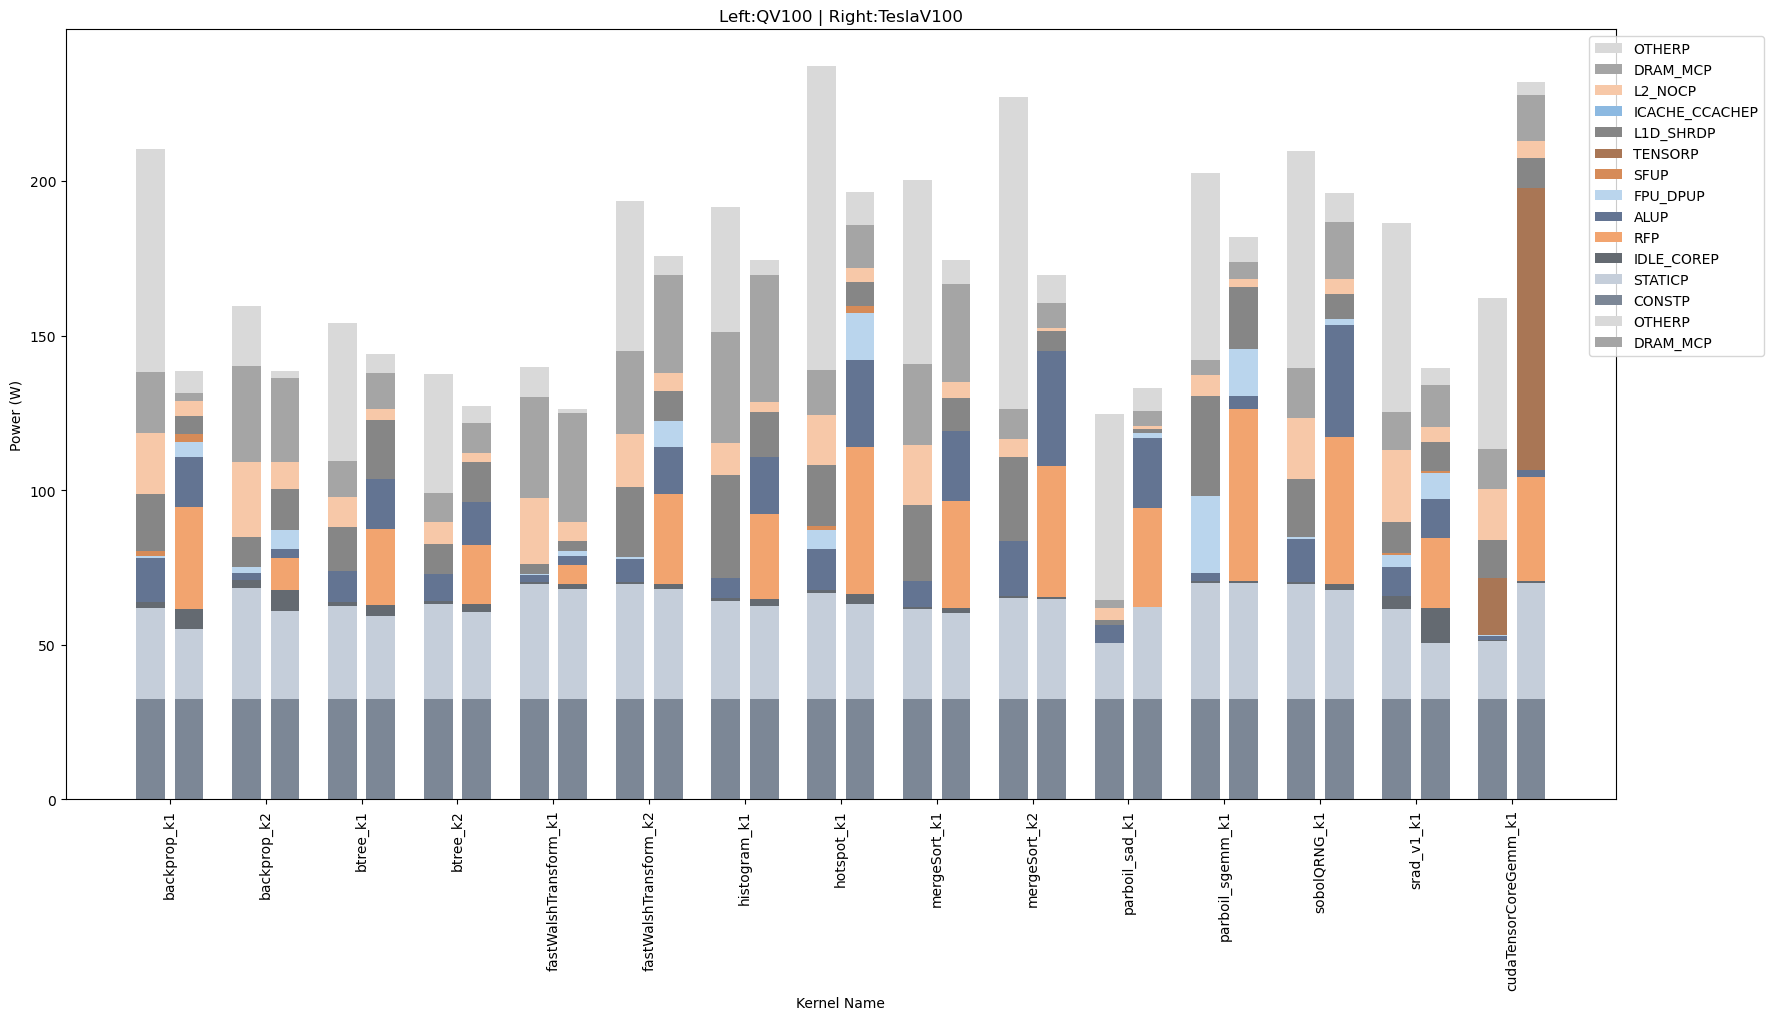

In [36]:
#Make a sidebyside with the QV100
# Set the x-axis labels
x_labels = new_qv100_df['KERNEL_NAME']

# Set the values for each stacked column
stack_values = new_qv100_df[stack_columns].values.T
x_axis = np.arange(len(stack_values[0]))
stack_values[0],x_axis
bar_width=0.3
bar_offset=0.2

# Plot the stacked QV100 bar graph
plt.figure(figsize=(20, 10))
plt.bar(x_axis-bar_offset, stack_values[0],width=bar_width, label=stack_columns[0],color=custom_colors[0])
for i in range(1, len(stack_columns)):
    plt.bar(x_axis-bar_offset, 
            stack_values[i], width=bar_width, 
            bottom=stack_values[:i].sum(axis=0), 
            label=stack_columns[i], 
            color=custom_colors[i%len(custom_colors)])
    
# Plot the stacked Tesla bar graph
stack_values = tesla_incomplete_df[stack_columns].values.T

plt.bar(x_axis+bar_offset, stack_values[0],width=bar_width, label=stack_columns[0],color=custom_colors[0])
for i in range(1, len(stack_columns)):
    plt.bar(x_axis+bar_offset, 
            stack_values[i], width=bar_width, 
            bottom=stack_values[:i].sum(axis=0), 
            label=stack_columns[i], 
            color=custom_colors[i%len(custom_colors)])
    
# # Rotate the x-labels by 90 degrees
plt.xticks(x_axis,x_labels,rotation=90)

# Add labels and title
plt.xlabel('Kernel Name')
plt.ylabel('Power (W)')
plt.title('Left:QV100 | Right:TeslaV100')

# Add legend
# Reverse the order of handles and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1][:len(x_axis)]
labels = labels[::-1][:len(x_axis)]

# Add legend with reversed order
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1,1),markerscale=10)
# # Show the plot
plt.show()


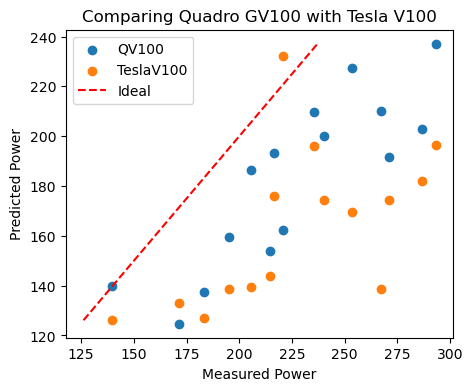

In [37]:

# Convert the values of the columns to floats
tesla_incomplete_df['kernel_avg_power'] = tesla_incomplete_df['kernel_avg_power'].astype(float)
tesla_incomplete_df['pwr_measured_HW_avg'] = tesla_incomplete_df['pwr_measured_HW_avg'].astype(float)

fig = plt.figure(figsize=(5, 4))
# Create the qv100 scatter plot (x,y) and add legend
plt.scatter(new_qv100_df['pwr_measured_HW_avg'], new_qv100_df['kernel_avg_power'], label='QV100')

# Create the tesla scatter plot and add legend
plt.scatter(tesla_incomplete_df['pwr_measured_HW_avg'], tesla_incomplete_df['kernel_avg_power'], label='TeslaV100')

# Add the x=y diagonal line
plt.plot([tesla_incomplete_df['kernel_avg_power'].min(), new_qv100_df['kernel_avg_power'].max()],
         [tesla_incomplete_df['kernel_avg_power'].min(), new_qv100_df['kernel_avg_power'].max()],
         color='red', linestyle='--', label='Ideal')

# for i, label in enumerate(tesla_incomplete_df['Kernel Names']):
#     plt.text(tesla_incomplete_df['pwr_measured_HW_avg'][i], tesla_incomplete_df['kernel_avg_power'][i], "T"+label[:5],
#              fontsize=8, ha='center', va='bottom')

# for i, label in enumerate(new_qv100_df['Kernel Names']):
#     plt.text(new_qv100_df['pwr_measured_HW_avg'][i], new_qv100_df['kernel_avg_power'][i], "Q"+label[:5],
#             fontsize=8, ha='center', va='bottom')

# Set labels and title
plt.xlabel('Measured Power')
plt.ylabel('Predicted Power')
plt.title('Comparing Quadro GV100 with Tesla V100')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [38]:
# tesla_incomplete_df = aggregate_predicted_values(get_data("TeslaV100_Incomplete"))
# tesla_kernel_name_to_hw_perf_name = {
# 'mergeSort_k4': 'mergeSort_k1',
# 'srad_v1-rodinia-3.1_k4': 'srad_v1-rodinia-3.1_k1',
# 'mergeSort_k1': 'mergeSort_k2',
# }
# print(tesla_incomplete_df['KERNEL_NAME'])
# for tesla_kernel,qv_kernel in tesla_kernel_name_to_hw_perf_name.items():
#     print(f"Looking for {tesla_kernel} row to be renamed as {qv_kernel}")
#     # Find rows with matching 'KERNEL_NAME' in qv_kernel
#     qv_rows = tesla_incomplete_df[tesla_incomplete_df['KERNEL_NAME'] == qv_kernel]

#     # Find rows with matching 'KERNEL_NAME' in tesla_kernel
#     tesla_rows = tesla_incomplete_df[tesla_incomplete_df['KERNEL_NAME'] == tesla_kernel]

#     if len(tesla_rows != 0):
#         print(f"Removing row named {qv_kernel}, replacing with {tesla_kernel}")
#         # Remove rows with matching 'KERNEL_NAME' in qv_kernel
#         # tesla_incomplete_df = tesla_incomplete_df[~(tesla_incomplete_df['KERNEL_NAME'] == qv_kernel)]

#         # Rename 'KERNEL_NAME' in qv_rows to qv_kernel
#         tesla_incomplete_df.loc[tesla_rows.index, 'KERNEL_NAME'] = qv_kernel+"TRUE"
#     else:
#         print(f"Could not find {tesla_kernel} to be renamed")
#     print()
    
    
# true_kernels = tesla_incomplete_df[tesla_incomplete_df['KERNEL_NAME'].str.contains("TRUE")]
# tesla_incomplete_df = tesla_incomplete_df[~tesla_incomplete_df['KERNEL_NAME'].isin(true_kernels["KERNEL_NAME"].str.replace("TRUE",''))]
# tesla_incomplete_df['KERNEL_NAME'] = tesla_incomplete_df["KERNEL_NAME"].str.replace("TRUE",'')
# tesla_incomplete_df

In [39]:
tesla_incomplete_df


,index,KERNEL_NAME,IBP,ICP,DCP,TCP,CCP,SHRDP,RFP,INTP,...,tmp_var,tmp_#samples,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
0,0,backprop_k1,1.139230,0.0,3.984540,0.0,0.0,1.940230,32.989100,9.760180,...,5.610667e-03,5,16.246490,4.679588,2.446040,5.924770,0.0,4.994080,2.475070,7.122710
1,1,backprop_k2,0.358721,0.0,13.374500,0.0,0.0,0.000038,10.229100,1.996320,...,9.762600e-02,5,3.181610,5.999575,0.000000,13.374538,0.0,8.602360,27.142380,2.321258
2,2,btree_k1,0.948049,0.0,19.010300,0.0,0.0,0.000000,24.739200,10.237600,...,0.000000e+00,5,15.977390,0.000000,0.000000,19.010300,0.0,3.557187,11.923930,6.041899
3,3,btree_k2,0.841325,0.0,13.169000,0.0,0.0,0.000000,18.967700,8.749960,...,0.000000e+00,5,13.823470,0.000000,0.000000,13.169000,0.0,2.695422,9.851810,5.318745
4,5,fastWalshTransform_k1,0.169906,0.0,3.209426,0.0,0.0,0.000000,6.188584,1.778277,...,4.444444e-07,5,2.876167,1.641988,0.000000,3.209426,0.0,6.357468,35.156968,1.077711
5,6,fastWalshTransform_k2,0.958243,0.0,2.919473,0.0,0.0,6.842317,29.153000,12.230433,...,2.777778e-04,5,15.309733,8.215343,0.000000,9.761790,0.0,5.783073,31.949517,6.157033
6,7,histogram_k1,0.777440,0.0,5.211785,0.0,0.0,9.498055,27.619000,16.662065,...,4.774889e-03,5,18.218345,0.000000,0.000000,14.709841,0.0,3.332127,40.806771,4.912619
7,8,hotspot_k1,1.644440,0.0,5.252970,0.0,0.0,2.634920,47.358100,23.675900,...,5.225111e-03,5,28.289850,15.178898,2.280770,7.887890,0.0,4.411620,13.758290,10.630180
8,9,mergeSort_k1,1.241768,0.0,6.422726,0.0,0.0,4.162497,34.602350,19.232683,...,4.870556e-02,5,22.808187,0.000000,0.000000,10.585223,0.0,5.216891,31.663292,7.933699
9,10,mergeSort_k2,1.370290,0.0,1.258900,0.0,0.0,5.133680,42.492400,33.541200,...,1.486222e-03,5,37.069640,0.000000,0.000000,6.392580,0.0,1.096873,8.153480,8.847170


In [40]:
# Set the random seed for reproducibility
np.random.seed(42)

# Define the number of bootstrap iterations
num_iterations = 1000  # You can increase this value for more robust results

# Create an empty array to store the MAPE values from each iteration
mape_values = np.empty(num_iterations)

# Perform bootstrapping
for i in range(num_iterations):
    # Sample with replacement from the dataset
    bootstrap_sample = tesla_incomplete_df.sample(frac=1, replace=True)
    
    # Calculate the absolute percentage error
    bootstrap_sample['Absolute Error'] = abs((bootstrap_sample['pwr_measured_HW_avg'] - bootstrap_sample['kernel_avg_power']) / bootstrap_sample['pwr_measured_HW_avg'])
    
    # Calculate the MAPE for the bootstrap sample
    mape_values[i] = bootstrap_sample['Absolute Error'].mean() * 100

# Calculate the absolute percentage error
tesla_incomplete_df['Absolute Error'] = abs((tesla_incomplete_df['pwr_measured_HW_avg'] - tesla_incomplete_df['kernel_avg_power']) / tesla_incomplete_df['pwr_measured_HW_avg'])

# Calculate the mean and interval for the MAPE
mean_mape = tesla_incomplete_df['Absolute Error'].mean() * 100
interval = np.percentile(mape_values, [2.5, 97.5])

# Print the MAPE as mean ± interval
print("MAPE: {:.2f}±{:.2f}%".format(mean_mape, interval[1] - mean_mape))


MAPE: 27.42±5.50%


In [41]:

x = tesla_incomplete_df['tmp_measured_HW_avg']
y = tesla_incomplete_df['pwr_measured_HW_avg']
coefficients = np.polyfit(x, y, 1)
m, c = coefficients
regression_line = f'y = {m:.2f}x + {c:.2f}'

# Calculate RMSE
y_pred = m * x + c
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate CV
cv = np.std(y) / np.mean(y)

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Print regression line equation, RMSE, CV, and correlation coefficient
print('Regression line:', regression_line)
print('RMSE:', rmse)
print('CV:', cv)
print('Correlation coefficient:', correlation_coefficient)



Regression line: y = 9.68x + -238.55
RMSE: 11.329302794674481
CV: 0.1870077595994951
Correlation coefficient: 0.963483095240343


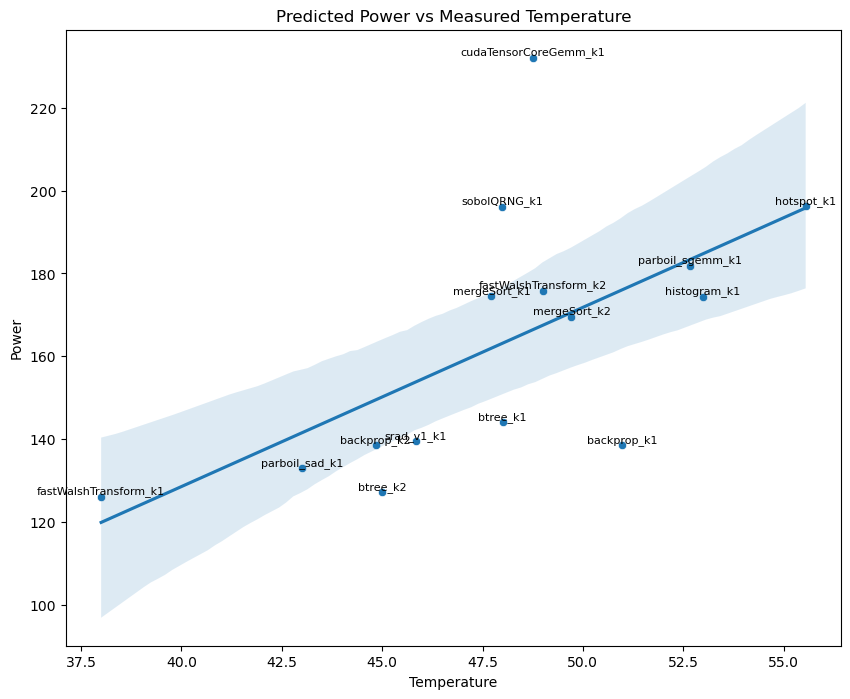

In [42]:
fig2=plt.figure(figsize=(10,8))

# Create the scatter plot
sns.scatterplot(y='kernel_avg_power', x='tmp_measured_HW_avg', data=tesla_incomplete_df)

# Add the regression curve
sns.regplot(y='kernel_avg_power', x='tmp_measured_HW_avg', data=tesla_incomplete_df, scatter=False)


for i, label in enumerate(tesla_incomplete_df['Kernel Names']):
    plt.text(tesla_incomplete_df['tmp_measured_HW_avg'][i], tesla_incomplete_df['kernel_avg_power'][i], label, fontsize=8, ha='center', va='bottom')

# Set labels and title
plt.ylabel('Power')
plt.xlabel('Temperature')
plt.title('Predicted Power vs Measured Temperature')

# Show the plot
plt.show()

In [43]:

x = tesla_incomplete_df['tmp_measured_HW_avg']
y = tesla_incomplete_df['kernel_avg_power']
coefficients = np.polyfit(x, y, 1)
m, c = coefficients
regression_line = f'y = {m:.2f}x + {c:.2f}'

# Calculate RMSE
y_pred = m * x + c
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate CV
cv = np.std(y) / np.mean(y)

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Print regression line equation, RMSE, CV, and correlation coefficient
print('Regression line:', regression_line)
print('RMSE:', rmse)
print('CV:', cv)
print('Correlation coefficient:', correlation_coefficient)


Regression line: y = 4.33x + -44.68
RMSE: 23.784115691169646
CV: 0.18365443379374358
Correlation coefficient: 0.6083278191703287


Text(0.5, 1.0, 'Predicted Power vs Measured Temperature')

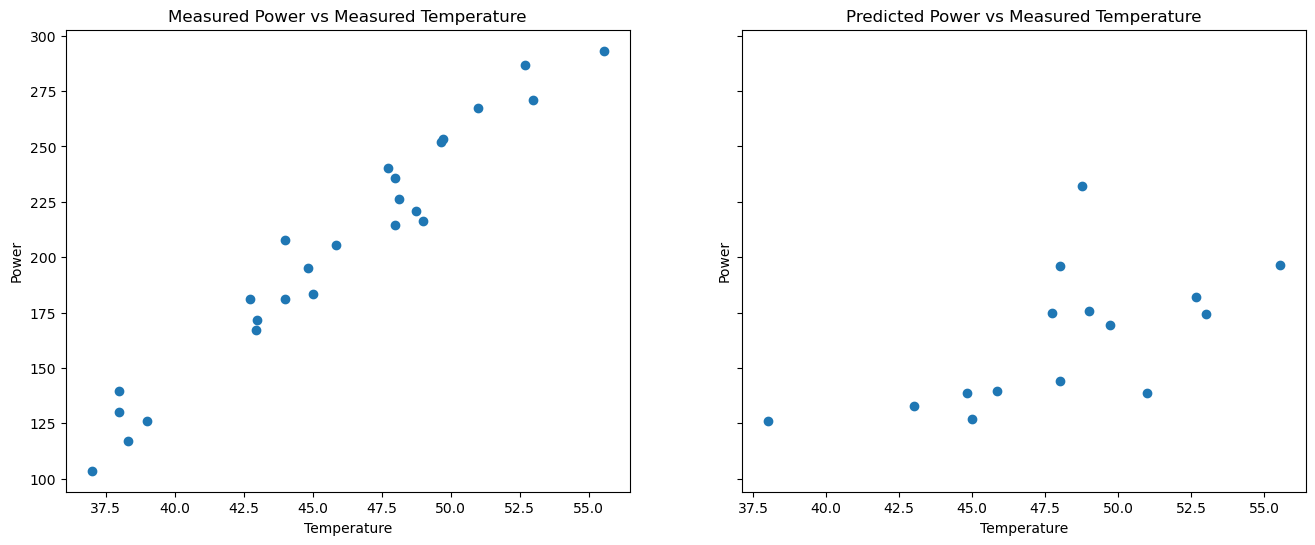

In [44]:
# Create a new figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6),sharey=True)

# Copy the plots from the first figure to the first subplot
axs[0].scatter(*fig1.get_axes()[0].collections[0].get_offsets().T)
axs[0].set_xlabel(fig1.get_axes()[0].get_xlabel())
axs[0].set_ylabel(fig1.get_axes()[0].get_ylabel())
axs[0].set_title(fig1.get_axes()[0].get_title())
axs[1].scatter(*fig2.get_axes()[0].collections[0].get_offsets().T)
axs[1].set_xlabel(fig2.get_axes()[0].get_xlabel())
axs[1].set_ylabel(fig2.get_axes()[0].get_ylabel())
axs[1].set_title(fig2.get_axes()[0].get_title())

-0.032529038470289234 9.823120287912293 -240.00037051855398


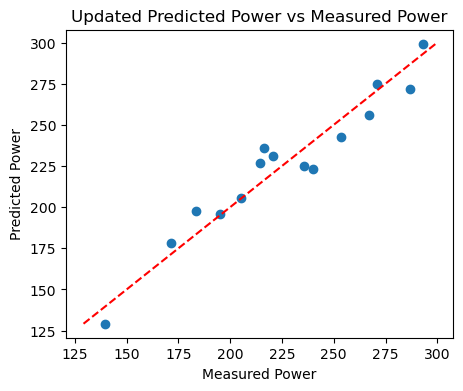

In [45]:

X = tesla_incomplete_df[['kernel_avg_power', 'tmp_measured_HW_avg']].values
y = tesla_incomplete_df['pwr_measured_HW_avg'].values

# Fit the linear regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Get the coefficients for the features
coefficient_kernel = regression_model.coef_[0]
coefficient_temperature = regression_model.coef_[1]
intercept = regression_model.intercept_
print(coefficient_kernel,coefficient_temperature,intercept)
# Update the power_prediction values based on temperature and kernel power
tesla_incomplete_df['updated_power_prediction'] = (tesla_incomplete_df['kernel_avg_power'] * coefficient_kernel) + (tesla_incomplete_df['tmp_measured_HW_avg'] * coefficient_temperature) + regression_model.intercept_


fig = plt.figure(figsize=(5,4))
# Create the scatter plot (x,y)
plt.scatter(tesla_incomplete_df['pwr_measured_HW_avg'], tesla_incomplete_df['updated_power_prediction'])

# Add the x=y diagonal line
plt.plot([tesla_incomplete_df['updated_power_prediction'].min(), tesla_incomplete_df['updated_power_prediction'].max()],
        [tesla_incomplete_df['updated_power_prediction'].min(), tesla_incomplete_df['updated_power_prediction'].max()],
        color='red', linestyle='--', label='x=y')

# for i, label in enumerate(tesla_incomplete_df['Kernel Names']):
#     plt.text(tesla_incomplete_df['pwr_measured_HW_avg'][i], tesla_incomplete_df['updated_power_prediction'][i], label,
#             fontsize=8, ha='center', va='bottom')

# Set labels and title
plt.xlabel('Measured Power')
plt.ylabel('Predicted Power')
plt.title('Updated Predicted Power vs Measured Power') #TeslaV100

# Show the plot
plt.show()
# tesla_incomplete_df['updated_power_prediction']

In [46]:
# Set the random seed for reproducibility
np.random.seed(42)

# Define the number of bootstrap iterations
num_iterations = 1000  # You can increase this value for more robust results

# Create an empty array to store the MAPE values from each iteration
mape_values = np.empty(num_iterations)

# Perform bootstrapping
for i in range(num_iterations):
    # Sample with replacement from the dataset
    bootstrap_sample = tesla_incomplete_df.sample(frac=1, replace=True)
    
    # Calculate the absolute percentage error
    bootstrap_sample['Absolute Error'] = abs((bootstrap_sample['pwr_measured_HW_avg'] - bootstrap_sample['updated_power_prediction']) / bootstrap_sample['pwr_measured_HW_avg'])
    
    # Calculate the MAPE for the bootstrap sample
    mape_values[i] = bootstrap_sample['Absolute Error'].mean() * 100

# Calculate the absolute percentage error
tesla_incomplete_df['Absolute Error'] = abs((tesla_incomplete_df['pwr_measured_HW_avg'] - tesla_incomplete_df['updated_power_prediction']) / tesla_incomplete_df['pwr_measured_HW_avg'])

# Calculate the mean and interval for the MAPE
mean_mape = tesla_incomplete_df['Absolute Error'].mean() * 100
interval = np.percentile(mape_values, [2.5, 97.5])

# Print the MAPE as mean ± interval
print("MAPE: {:.2f}±{:.2f}%".format(mean_mape, interval[1] - mean_mape))


MAPE: 4.54±1.33%


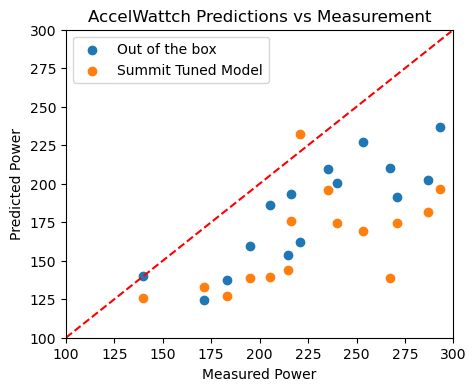

In [50]:

# Convert the values of the columns to floats
tesla_incomplete_df['kernel_avg_power'] = tesla_incomplete_df['kernel_avg_power'].astype(float)
tesla_incomplete_df['pwr_measured_HW_avg'] = tesla_incomplete_df['pwr_measured_HW_avg'].astype(float)

fig = plt.figure(figsize=(5, 4))
# Create the qv100 scatter plot (x,y) and add legend
plt.scatter(new_qv100_df['pwr_measured_HW_avg'], new_qv100_df['kernel_avg_power'], label='Out of the box')

# Create the tesla scatter plot and add legend
plt.scatter(tesla_incomplete_df['pwr_measured_HW_avg'], tesla_incomplete_df['kernel_avg_power'], label='Summit Tuned Model')



